In [1]:
# %pip install torchvision

In [2]:
import eda_helpers as eda

/home/ubuntu/eda/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DATASET: https://huggingface.co/datasets/flwrlabs/fed-isic2019
Labels meaning = https://challenge.isic-archive.com/landing/2019/

```
@inproceedings{NEURIPS2022_232eee8e,
 author = {Ogier du Terrail, Jean and Ayed, Samy-Safwan and Cyffers, Edwige and Grimberg, Felix and He, Chaoyang and Loeb, Regis and Mangold, Paul and Marchand, Tanguy and Marfoq, Othmane and Mushtaq, Erum and Muzellec, Boris and Philippenko, Constantin and Silva, Santiago and Tele\'{n}czuk, Maria and Albarqouni, Shadi and Avestimehr, Salman and Bellet, Aur\'{e}lien and Dieuleveut, Aymeric and Jaggi, Martin and Karimireddy, Sai Praneeth and Lorenzi, Marco and Neglia, Giovanni and Tommasi, Marc and Andreux, Mathieu},
 booktitle = {Advances in Neural Information Processing Systems},
 editor = {S. Koyejo and S. Mohamed and A. Agarwal and D. Belgrave and K. Cho and A. Oh},
 pages = {5315--5334},
 publisher = {Curran Associates, Inc.},
 title = {FLamby: Datasets and Benchmarks for Cross-Silo Federated Learning in Realistic Healthcare Settings},
 url = {https://proceedings.neurips.cc/paper_files/paper/2022/file/232eee8ef411a0a316efa298d7be3c2b-Paper-Datasets_and_Benchmarks.pdf},
 volume = {35},
 year = {2022}
}

```

In [3]:
# Variables
DATASET_PATH = 'flwrlabs/fed-isic2019'
LABELS = list(map(str, range(8)))
GROUP_COL = 'center'

In [4]:
data = eda.download_dataset(DATASET_PATH, 'train')
data.head()

image  center  label
0  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0      1
1  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0      2
2  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0      1
3  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0      3
4  <PIL.JpegImagePlugin.JpegImageFile image mode=...       0      1

In [5]:
data.isna().sum(axis=0)
# no misses

image     0
center    0
label     0
dtype: int64

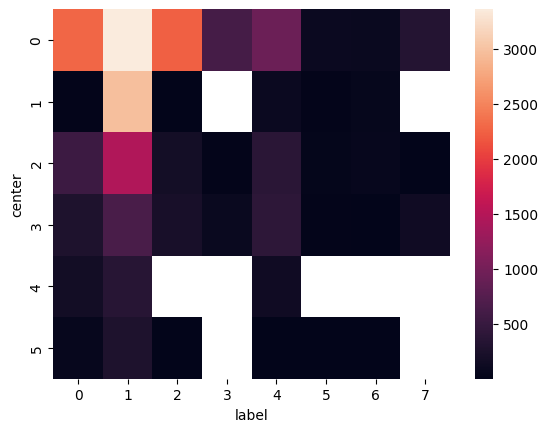

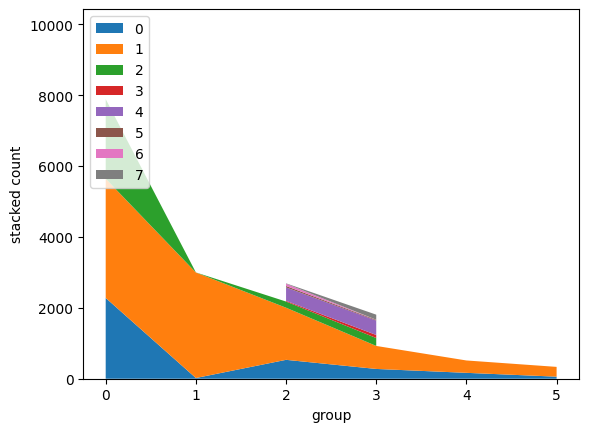

In [6]:
eda.twod_label_distribution(data, 'label', GROUP_COL, LABELS)

В каких-то центрах нет некоторых label-ов. Данные прекрасно перекошены в этом смысле. Но для DDL стоит стереть center

In [7]:
DOMAIN = data.center.unique()

In [8]:
data.image.apply(lambda x: x.size).unique()
# есть разные размеры фото

array([(224, 224), (298, 224), (337, 224), (334, 224), (336, 224),
       (320, 224), (317, 224)], dtype=object)

In [12]:
data['image'] = data['image'].map(lambda x: x.resize((224, 224), eda.Image.Resampling.LANCZOS))

In [14]:
data.image.apply(lambda x: x.size).unique()
# теперь норм

array([(224, 224)], dtype=object)

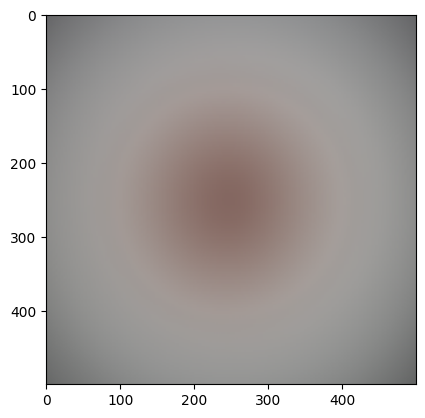

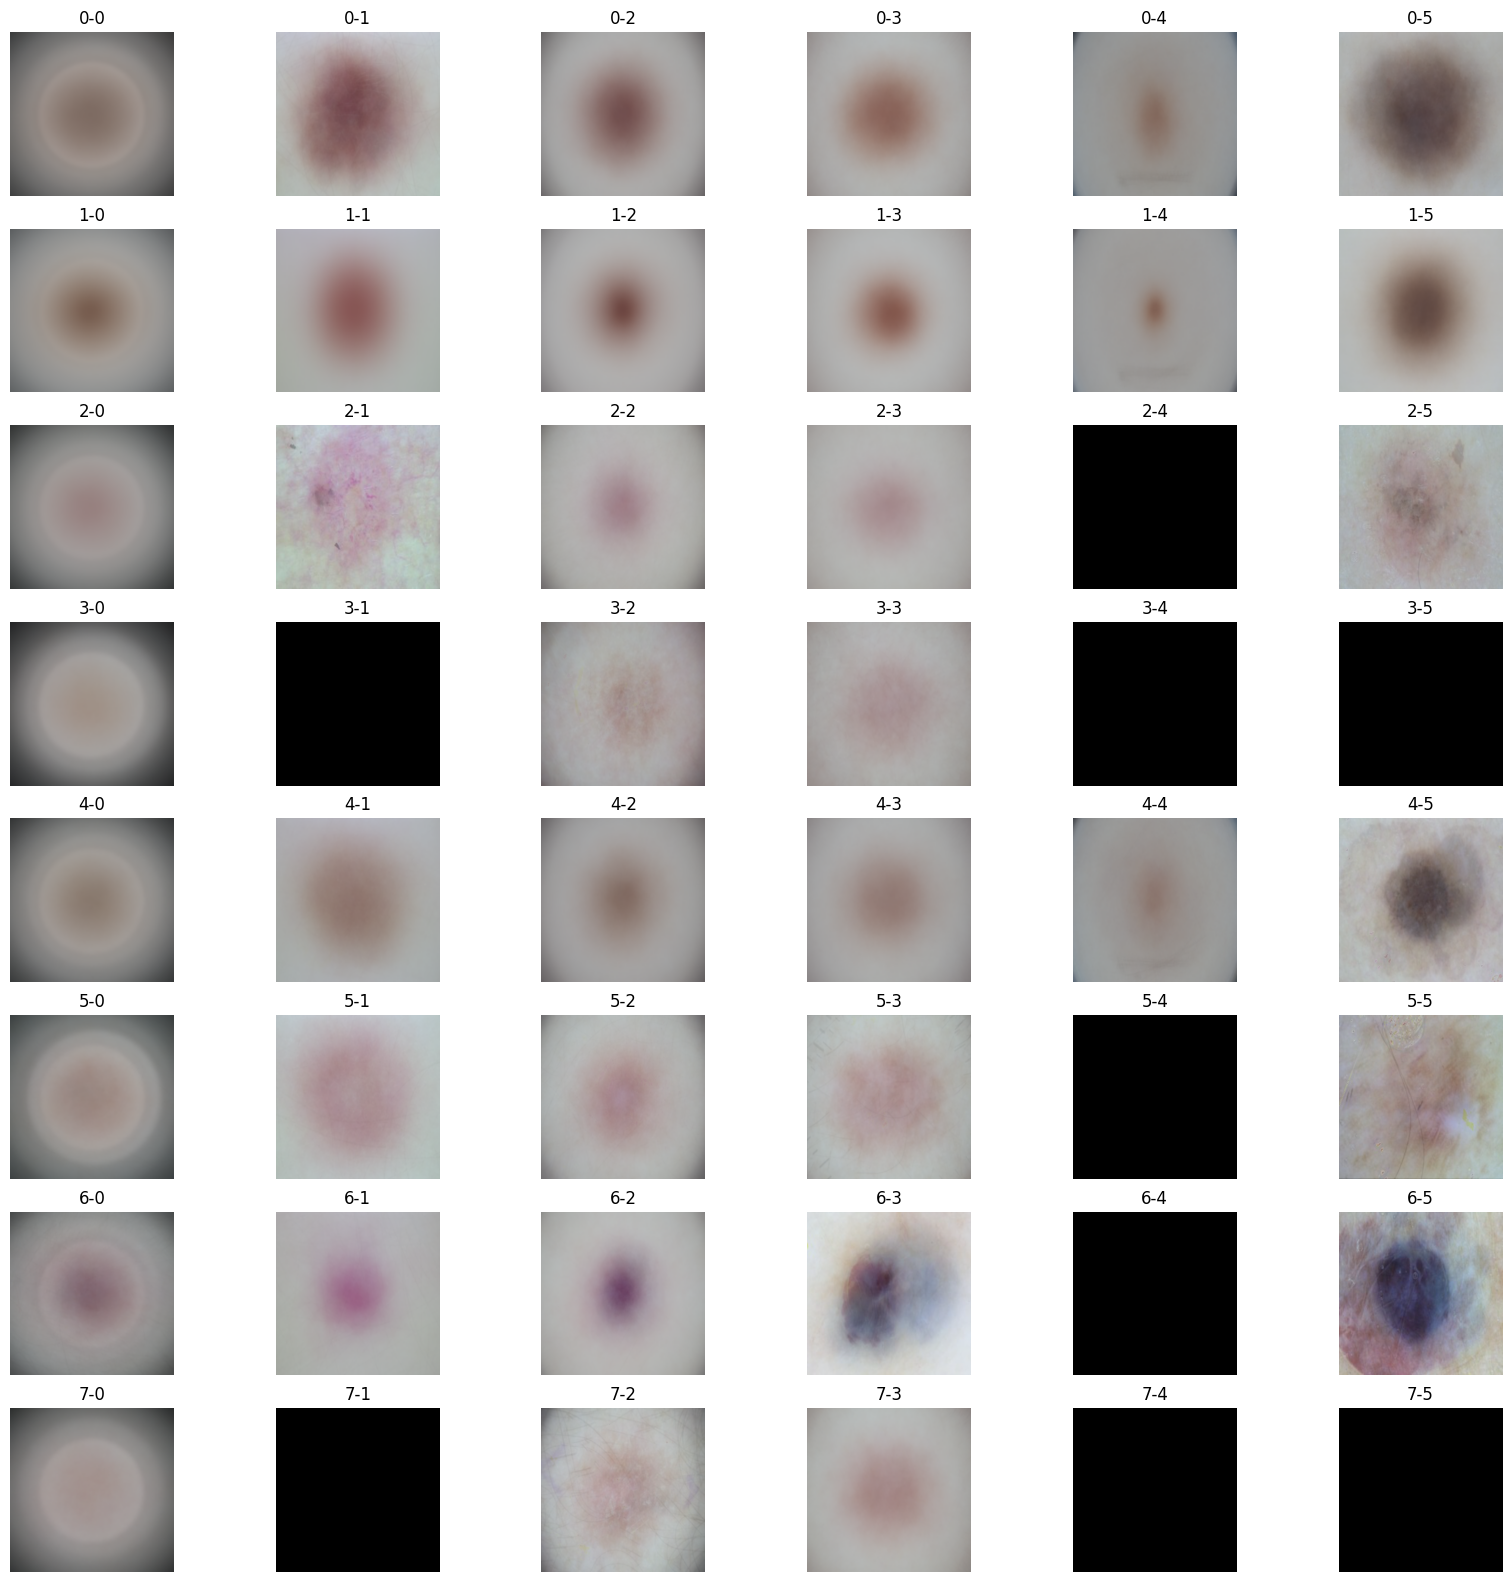

In [25]:
eda.draw_image_over_groups(data, lambda x: eda.Image.fromarray(eda.find_mean_photo(x)).resize((500, 500)), DOMAIN, LABELS, GROUP_COL, 'label', 'image')

как будто по цвету можно определить тип плюс минус хорошо. Пока не уверена, это хорошо или плохо для моей задачи

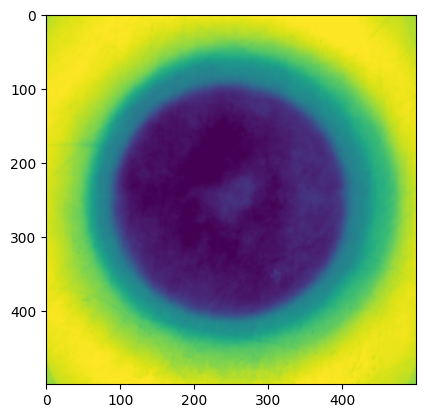

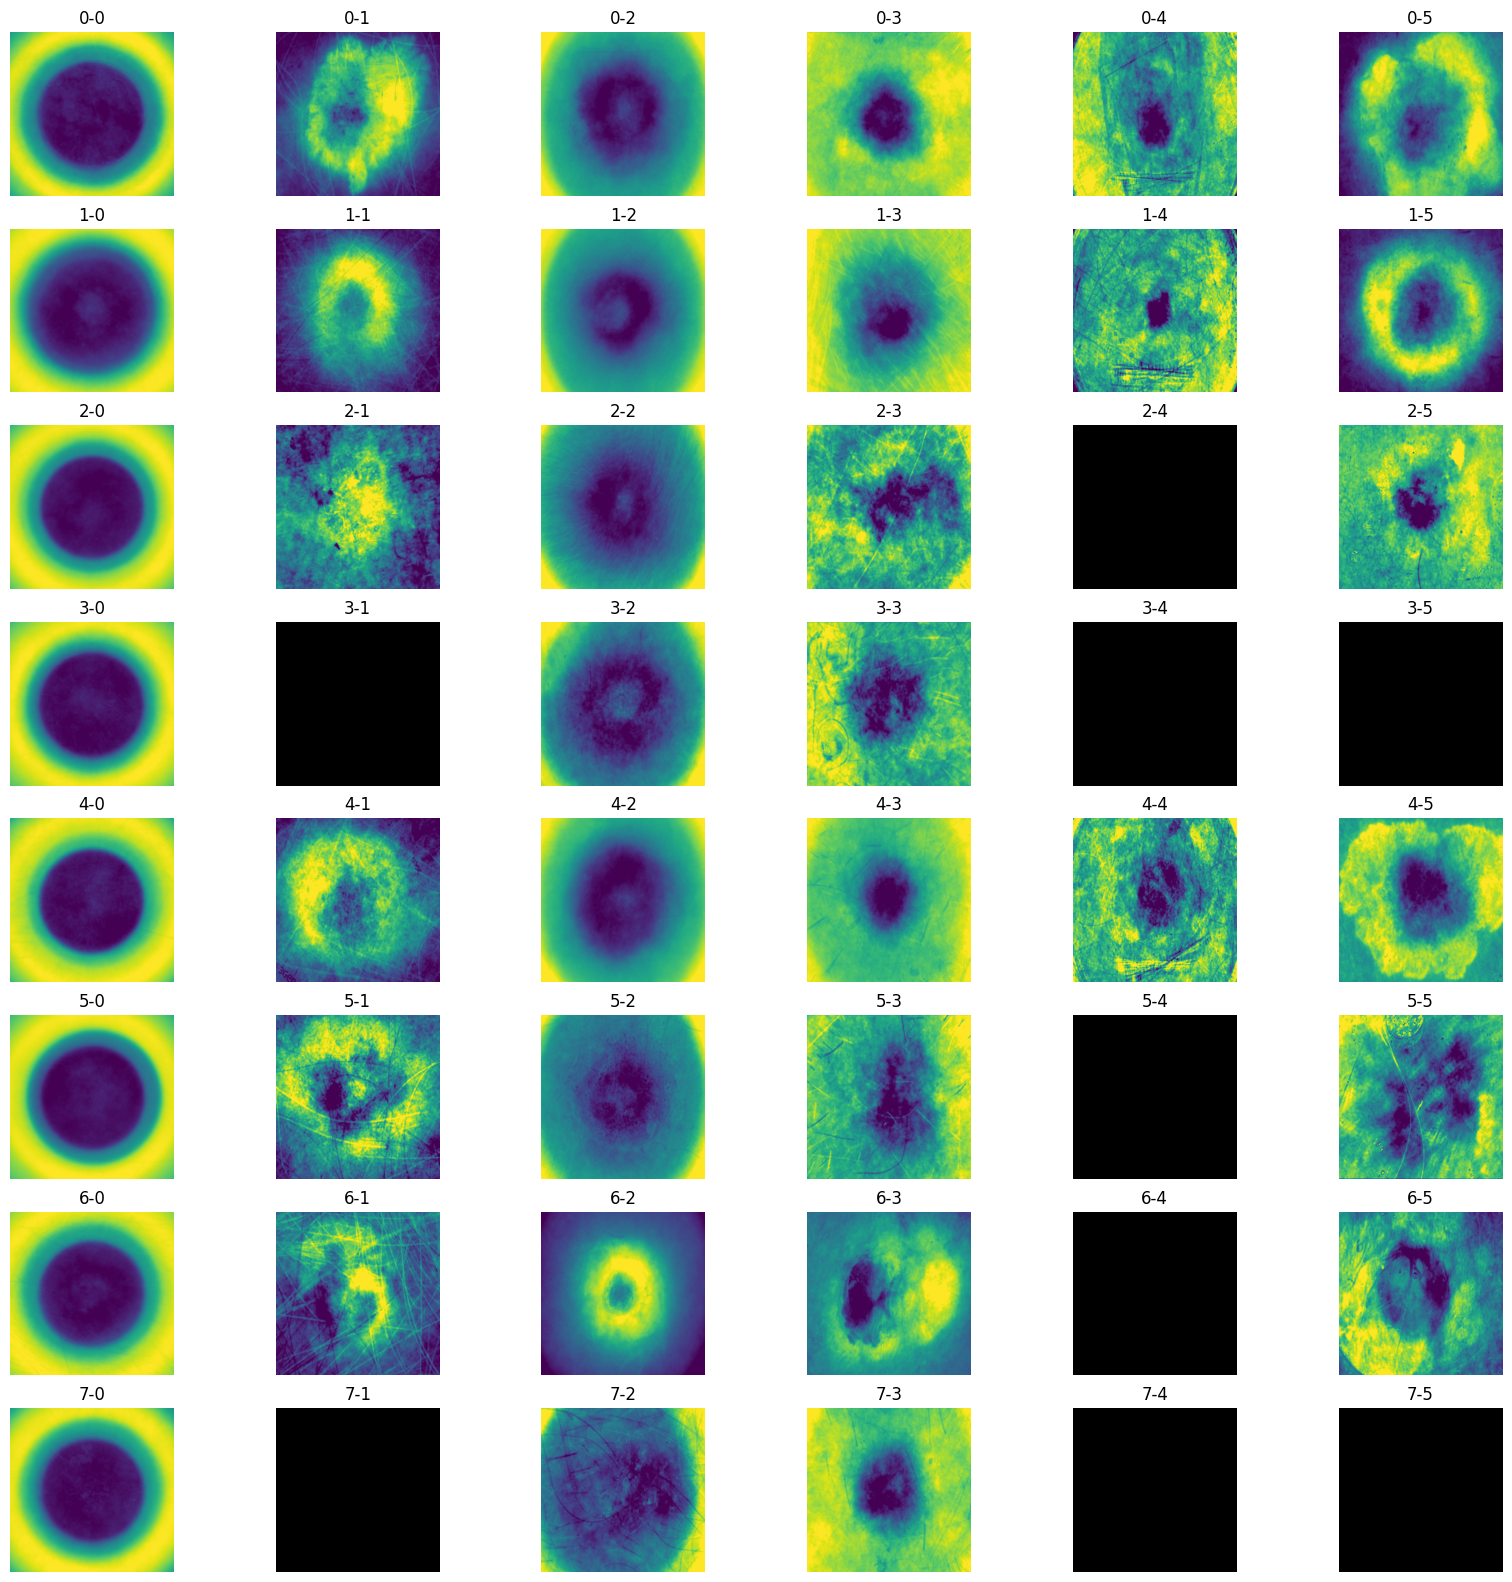

In [31]:
eda.draw_image_over_groups(data, lambda x: eda.Image.fromarray(eda.find_eigenphoto(x)).resize((500, 500)), DOMAIN, LABELS, GROUP_COL, 'label', 'image', random=True)

там где отчетливое изображение, там видимо данных мало. А так чисто по простой форме как будто понять будет сложно, они условно не подлежат одну паттерну ориентации (как например лица где есть глаза и тд). Единственно, находится круг но оно все круг

In [ ]:
# eda.see_samples(data, LABELS, DOMAIN, 1, 'image', GROUP_COL, 'label')

в целом выше видно

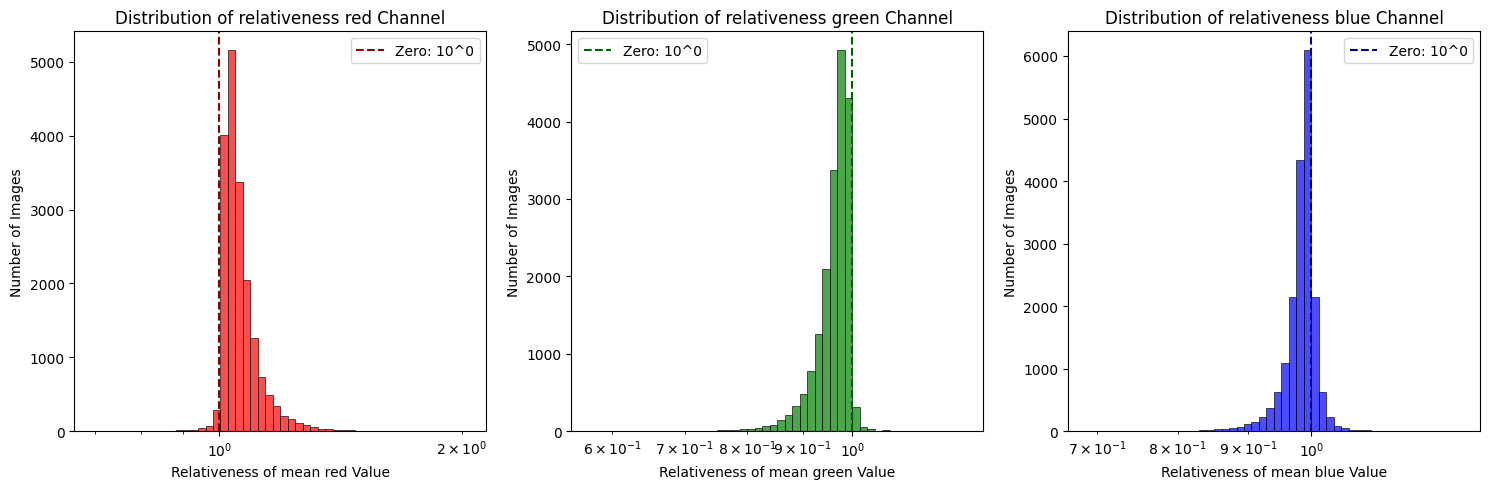

In [32]:
eda.draw_color_distrib(*eda.get_colors(eda.all_generator(data, 'image')))

ожидаемый перекос в красный. Если везде так будет, то можно ничего не менять. Правда есть еще синий цвет, так что смотрим на эти два показателя

0-0


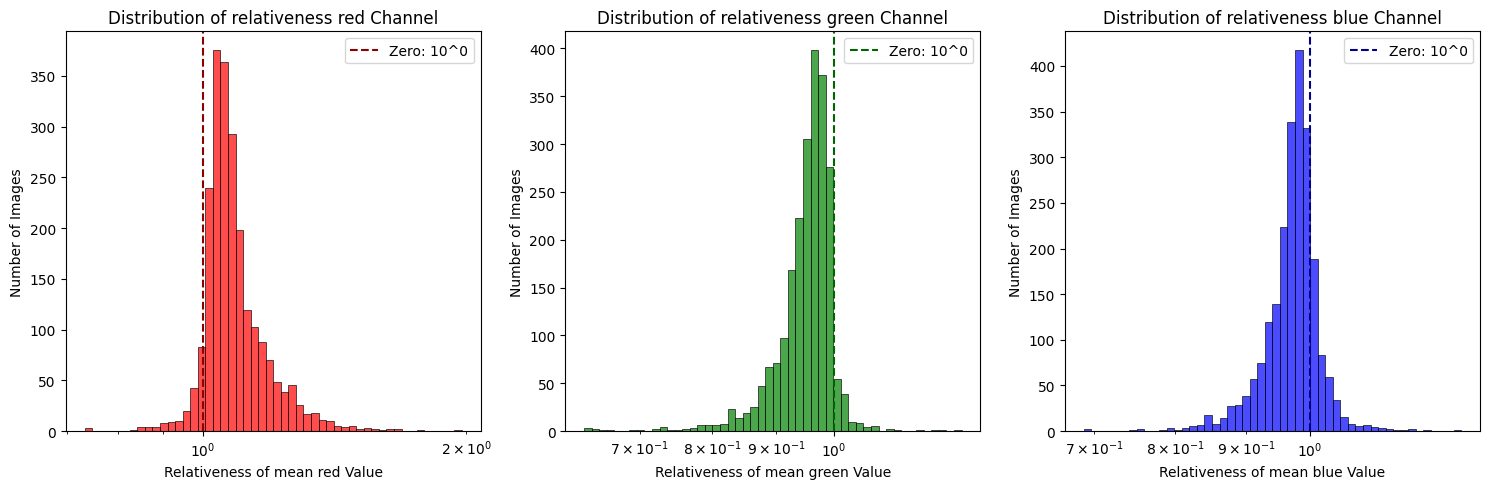

0-1


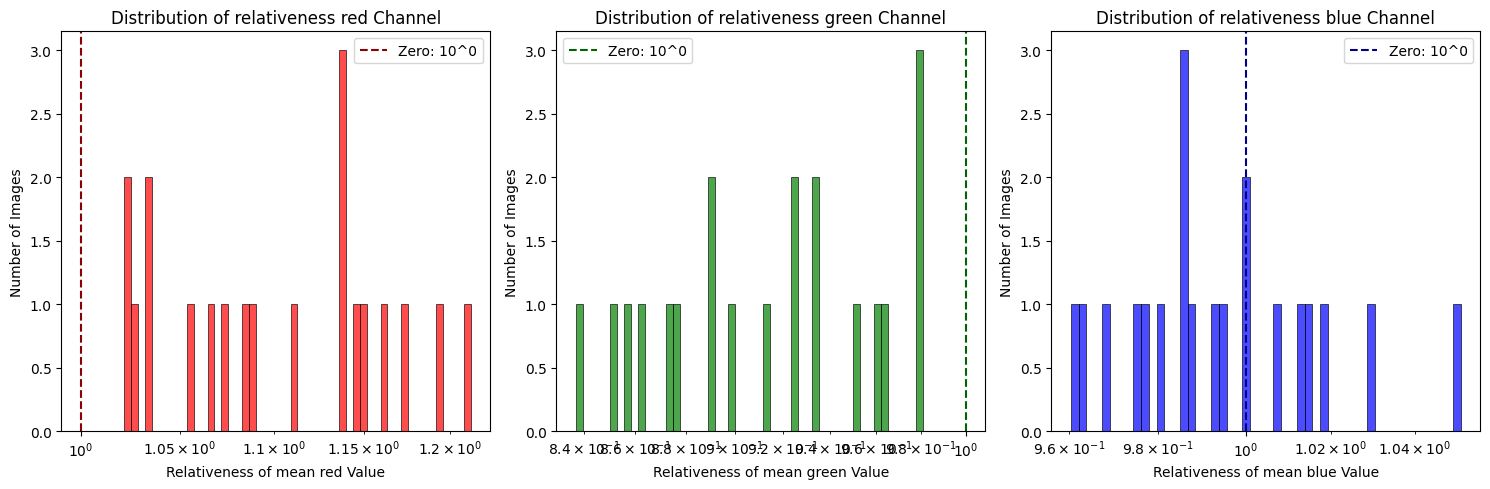

0-2


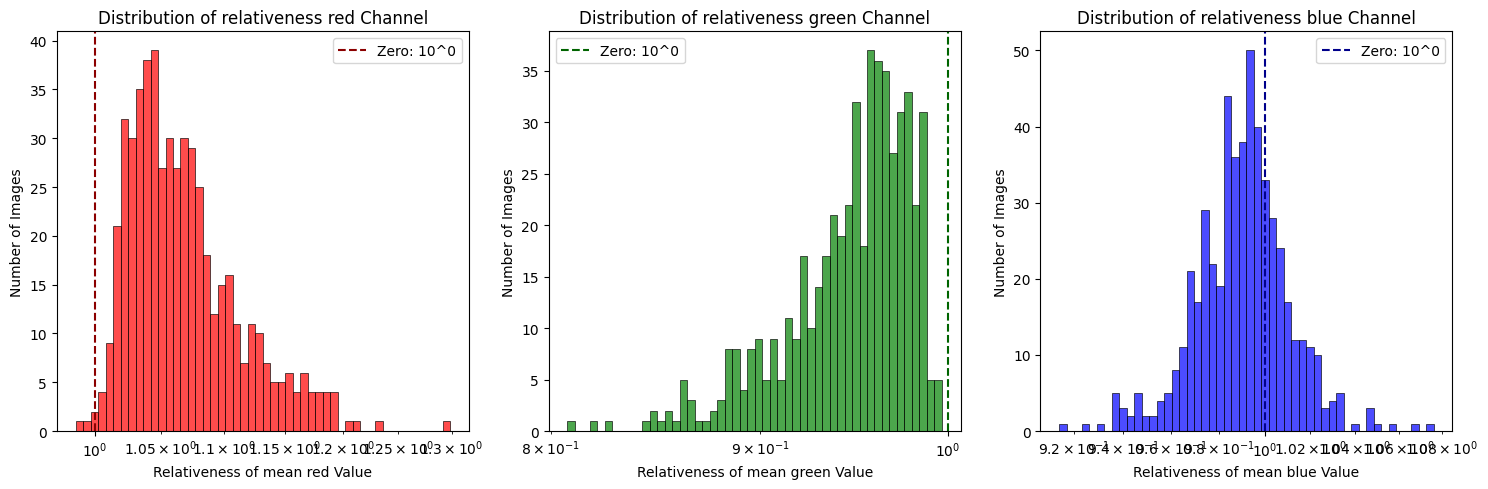

0-3


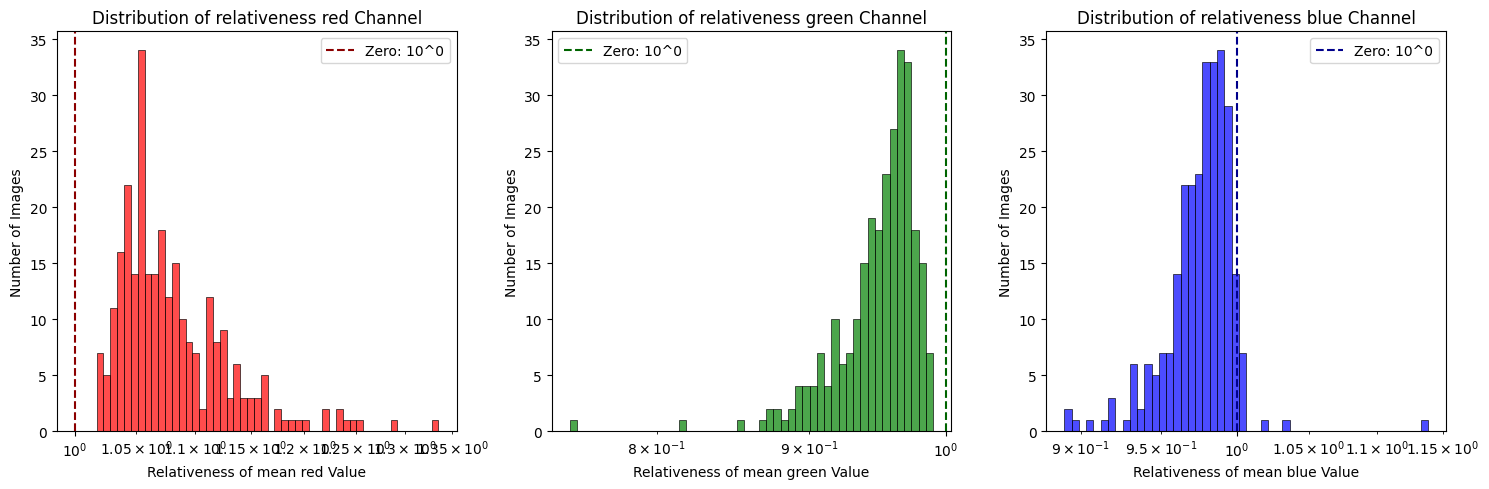

0-4


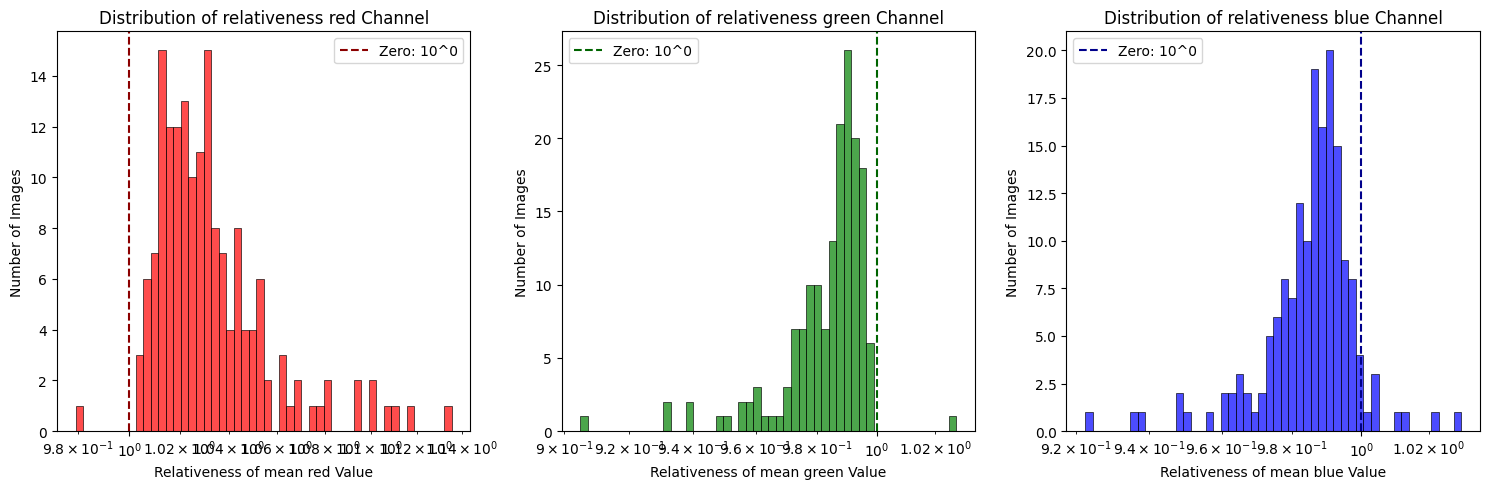

0-5


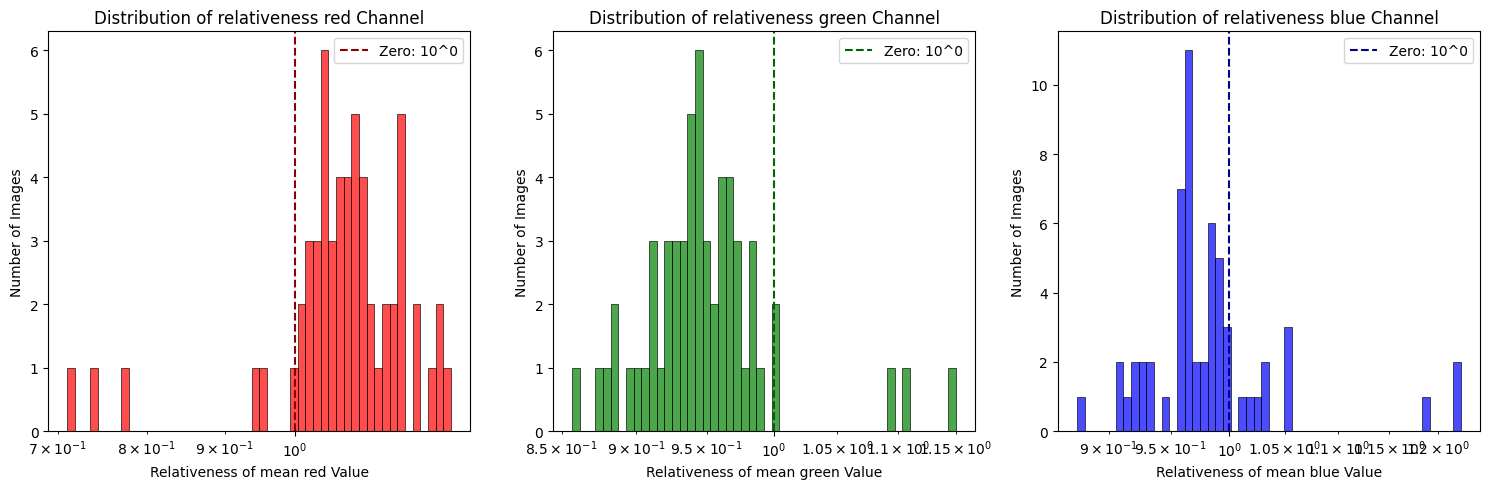

1-0


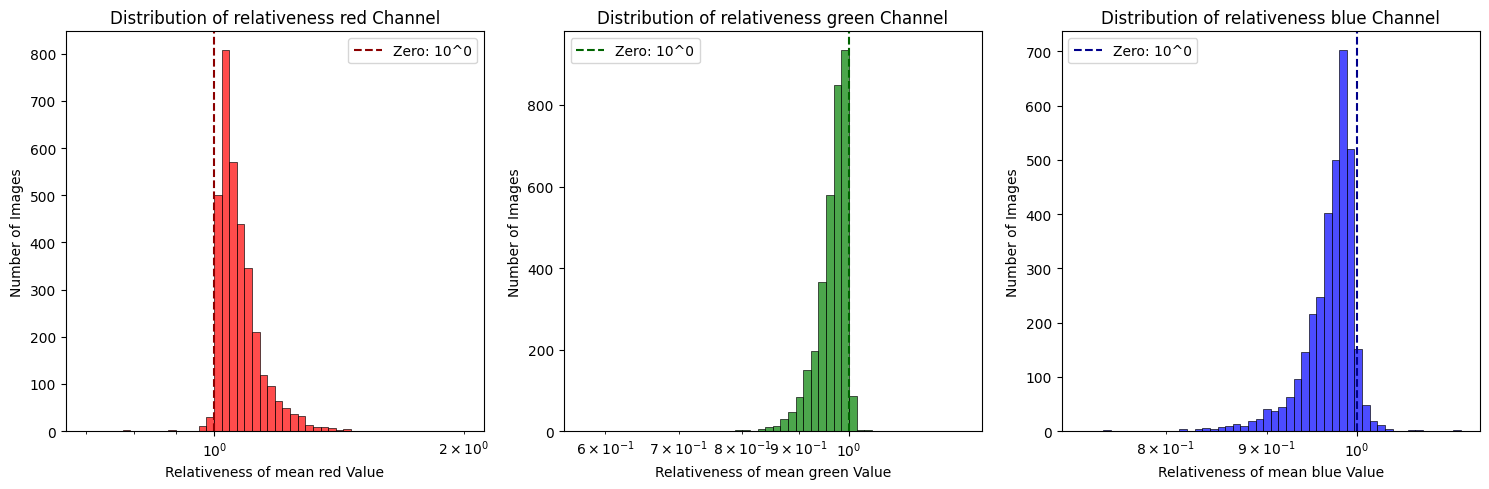

1-1


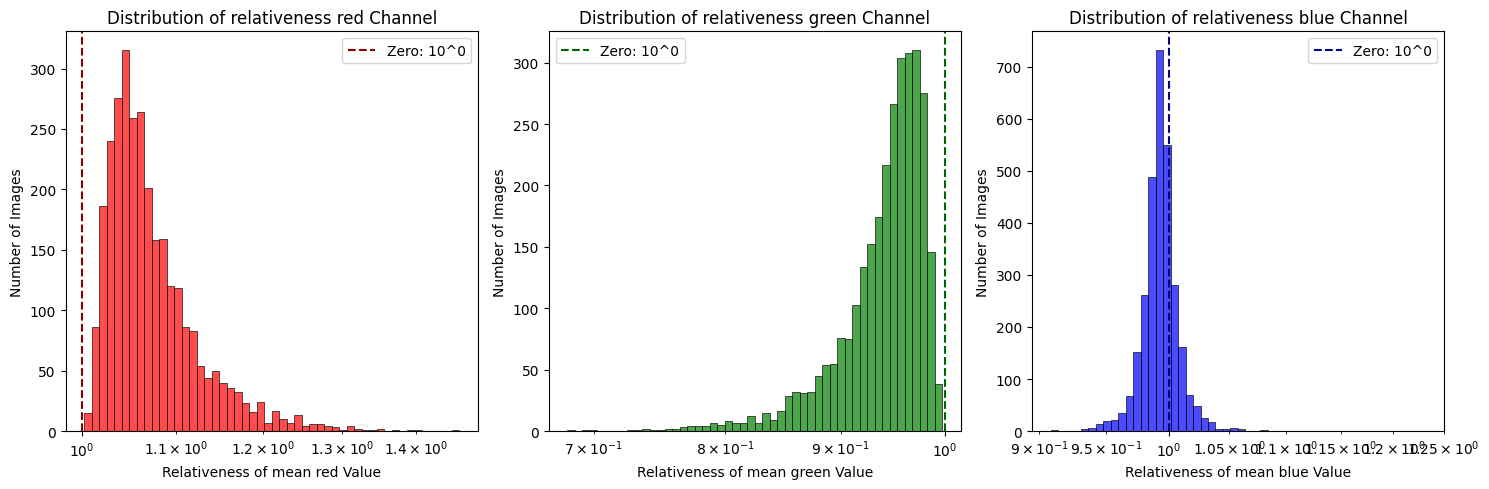

1-2


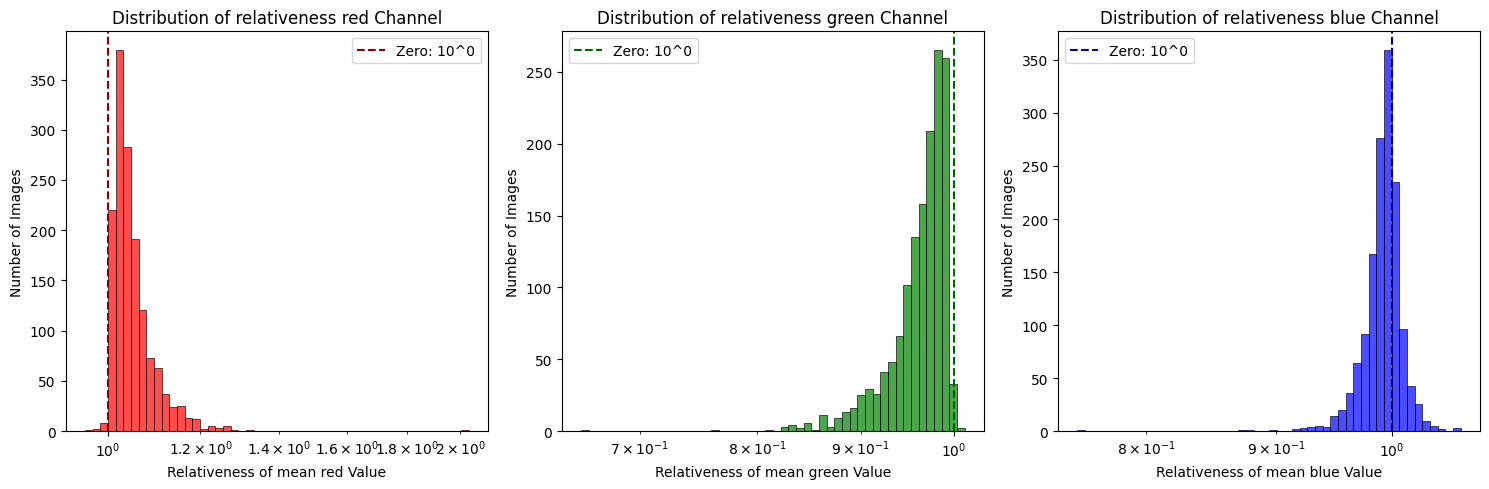

1-3


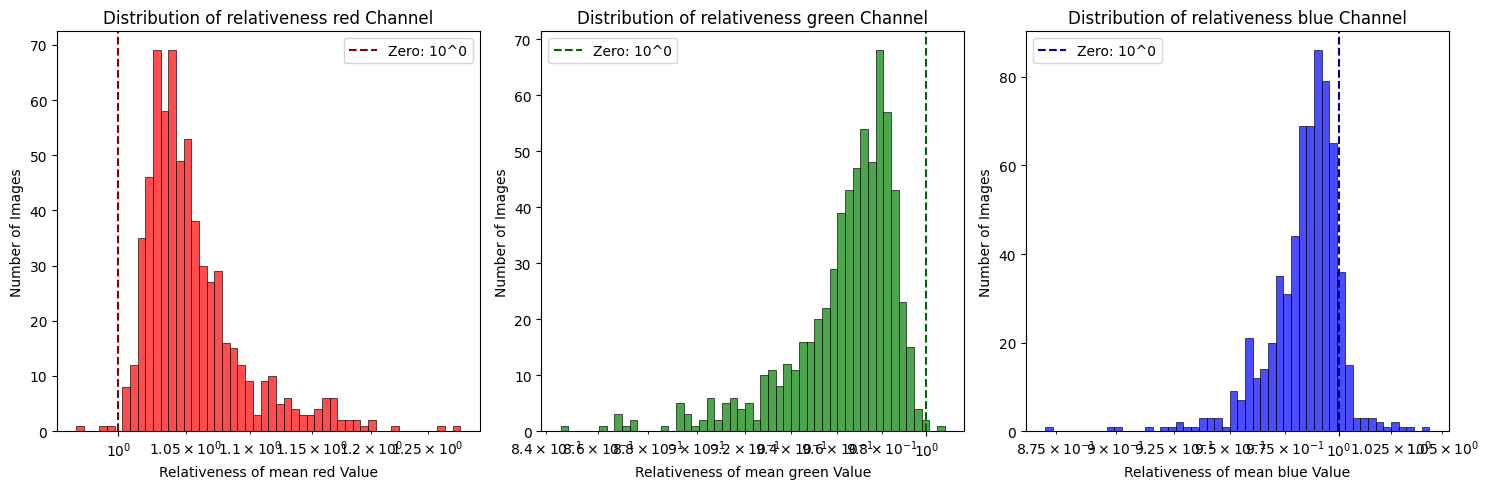

1-4


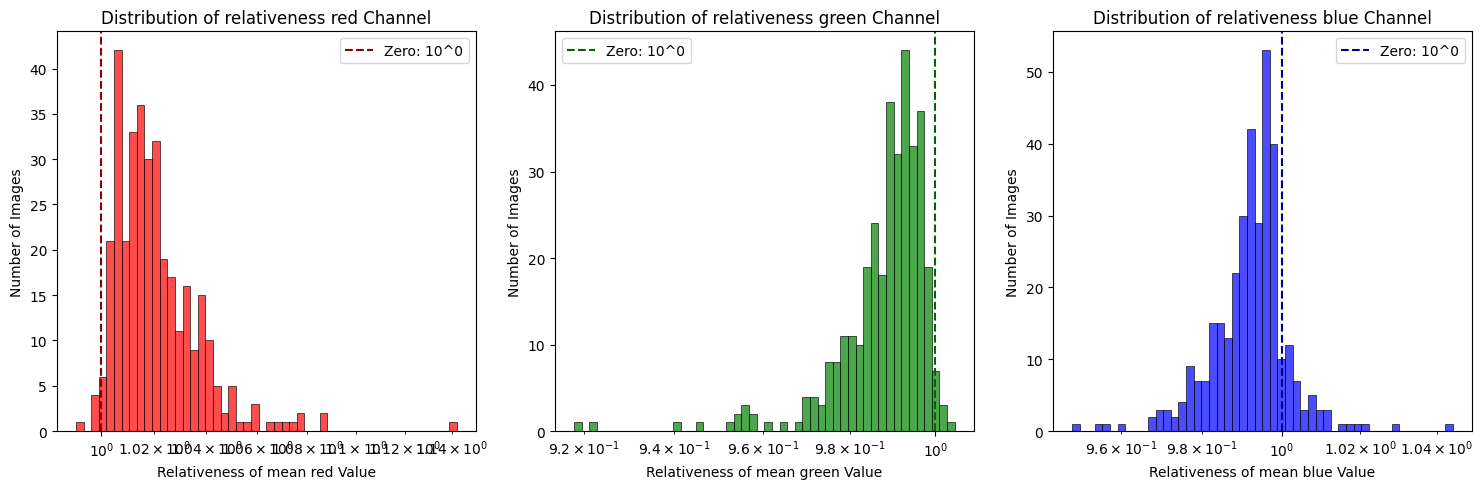

1-5


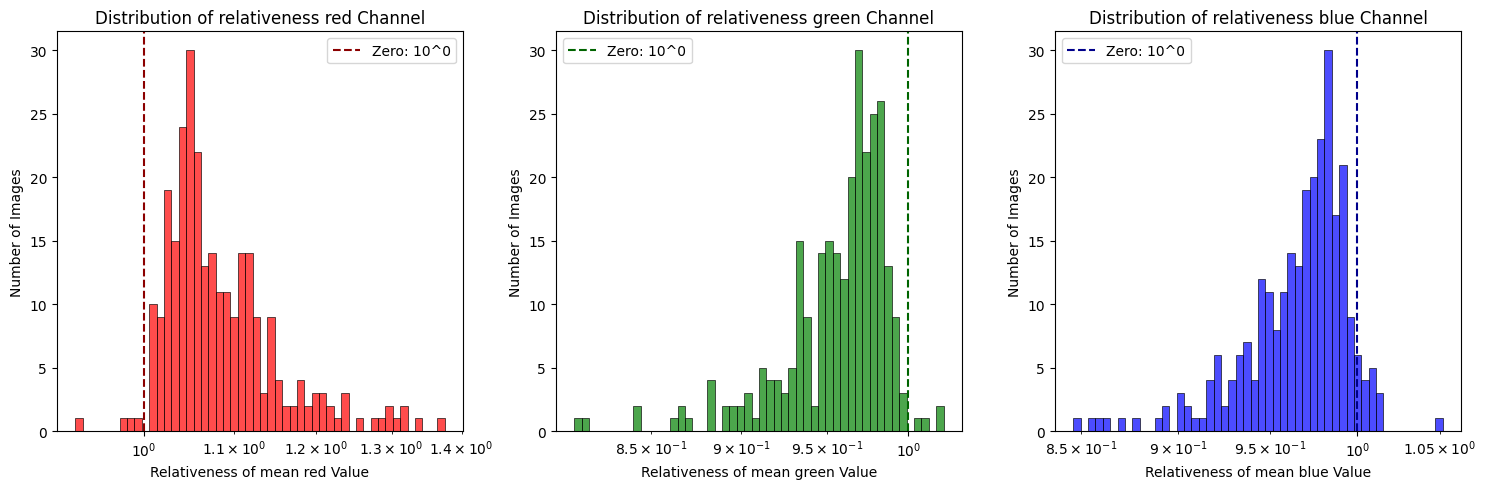

2-0


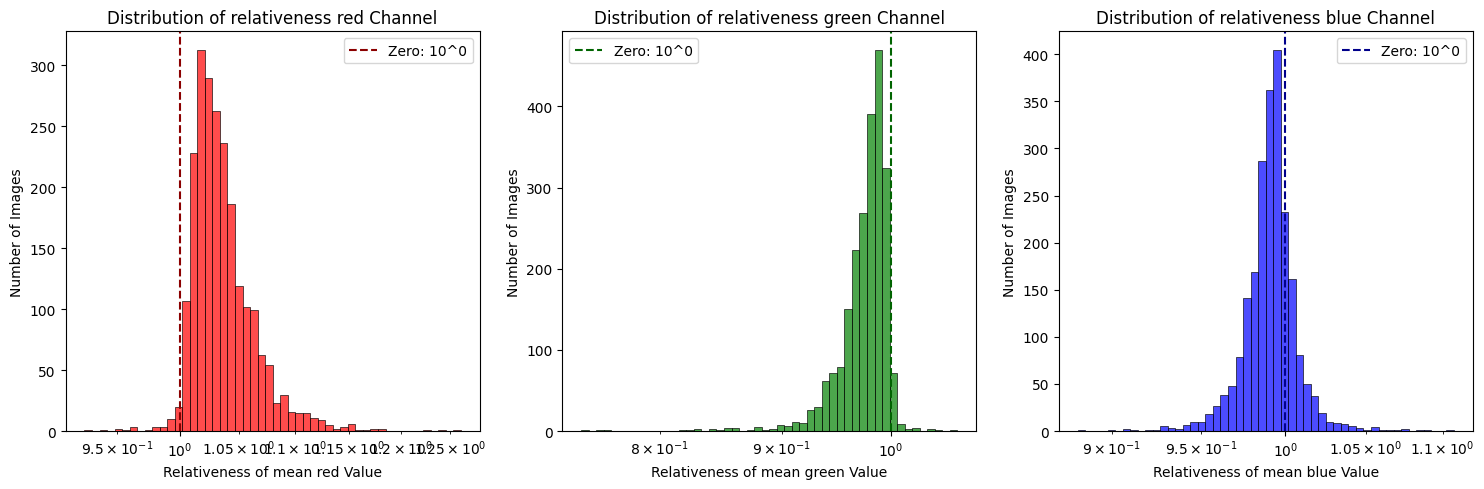

2-1


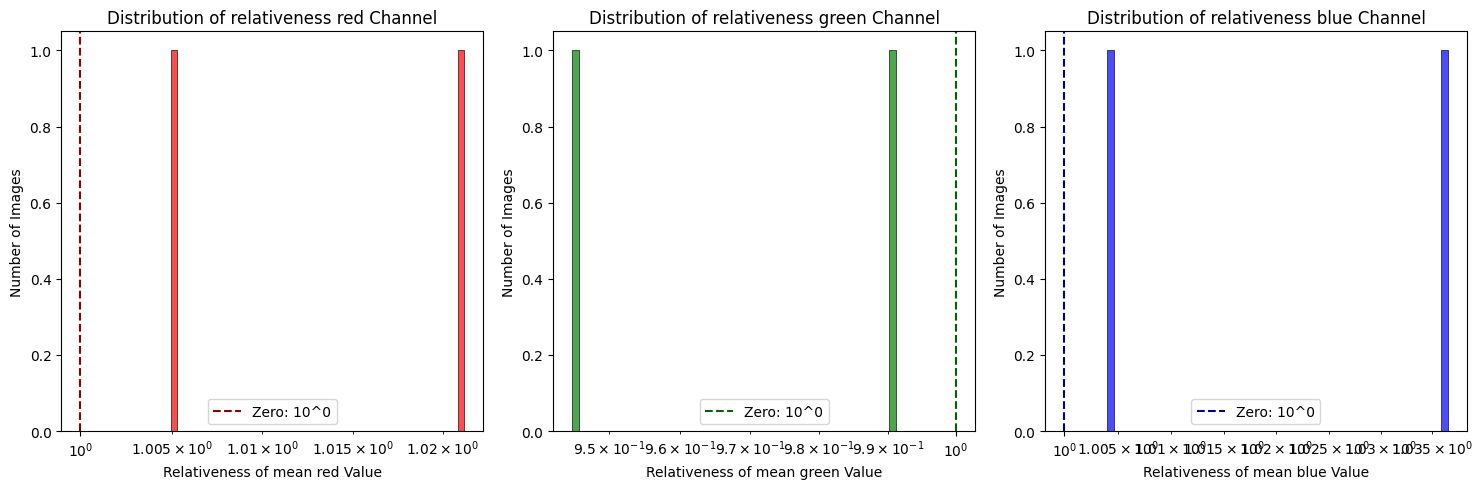

2-2


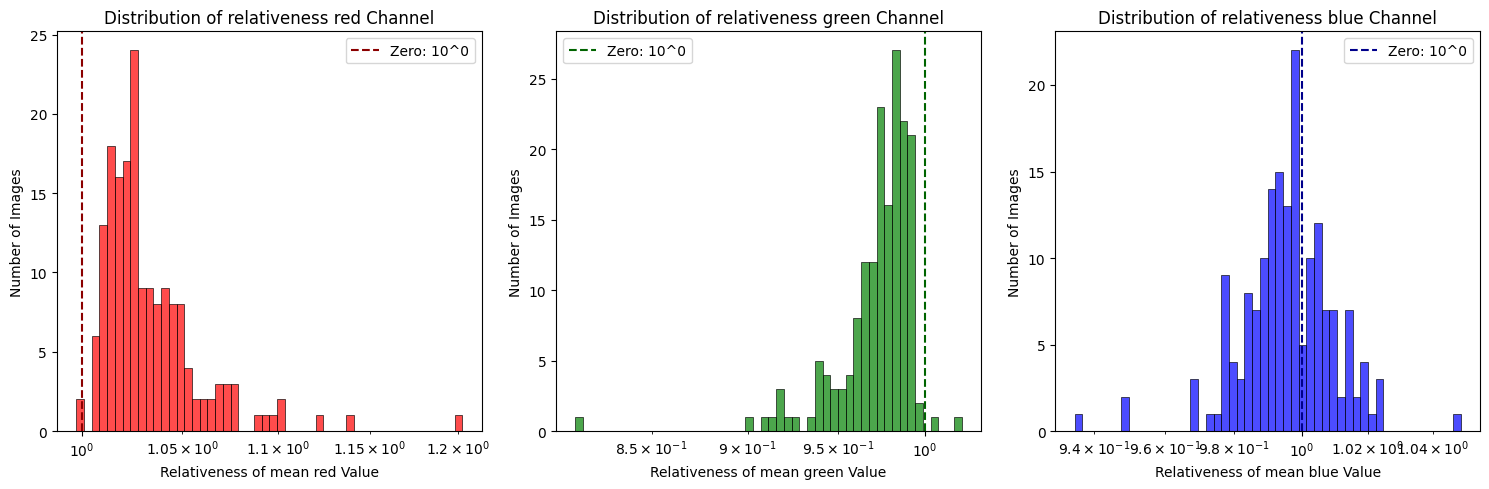

2-3


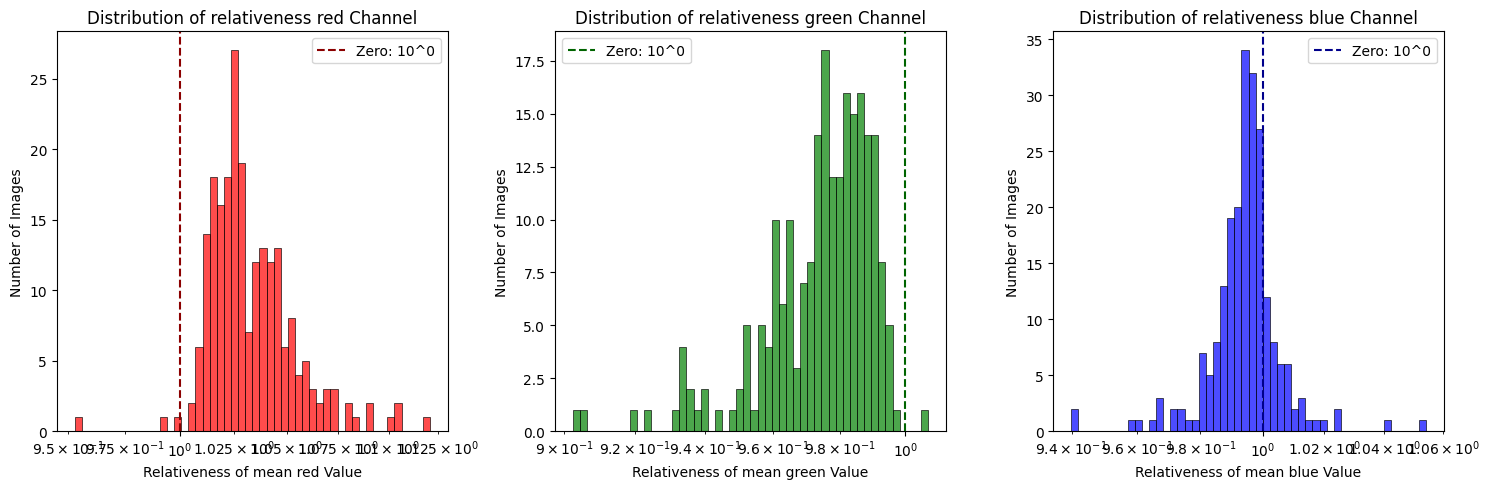

2-4


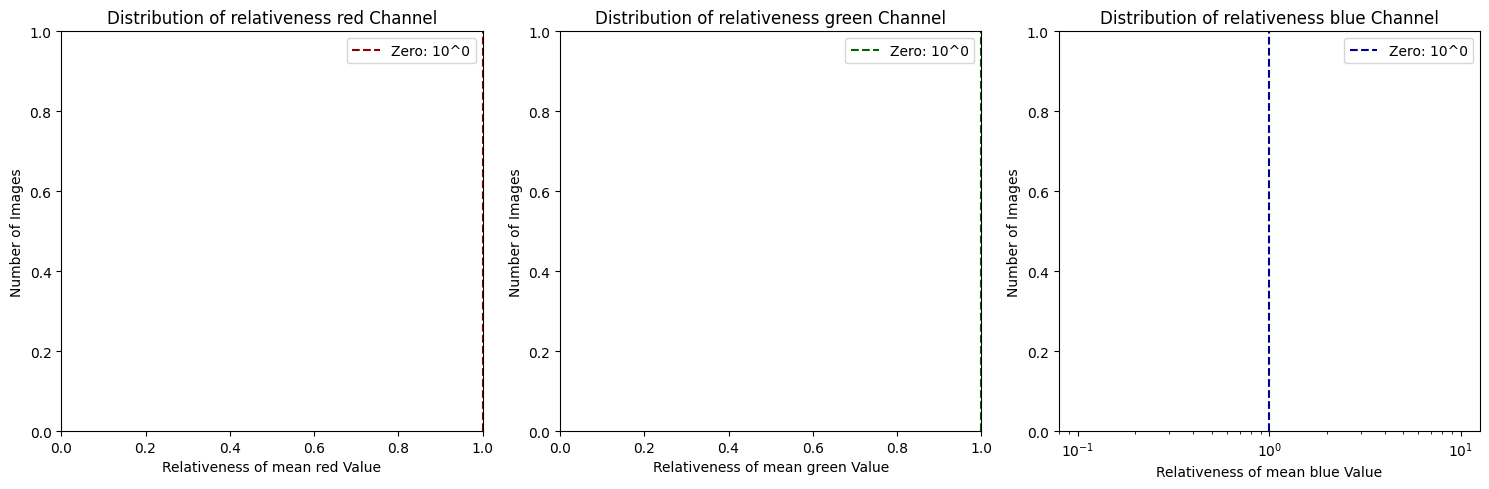

2-5


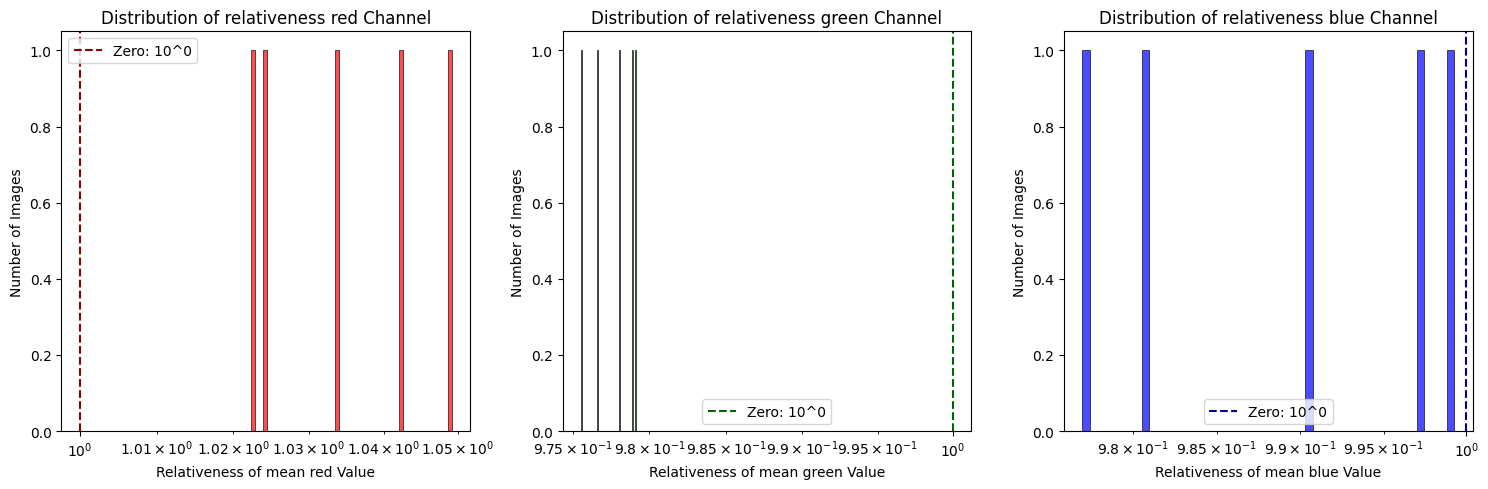

3-0


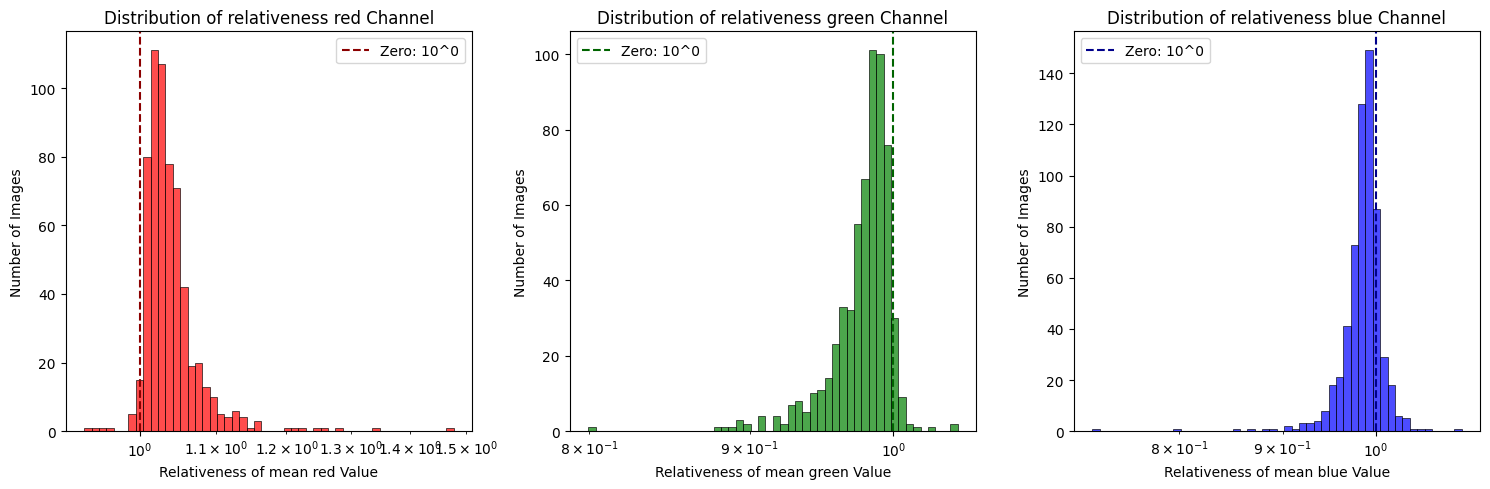

3-1


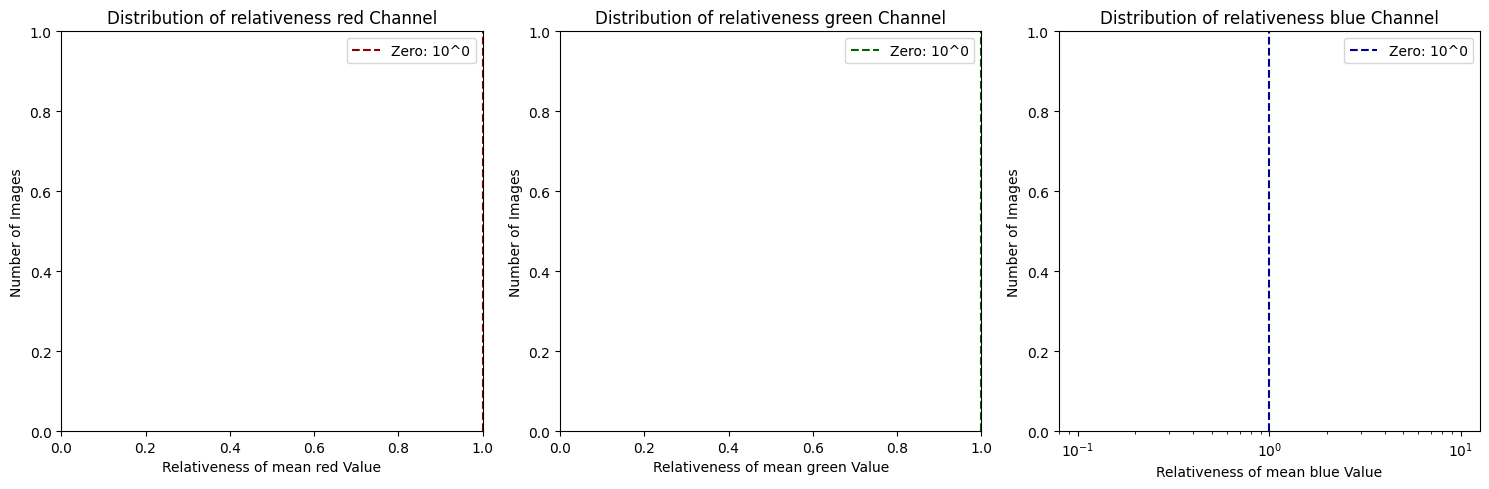

3-2


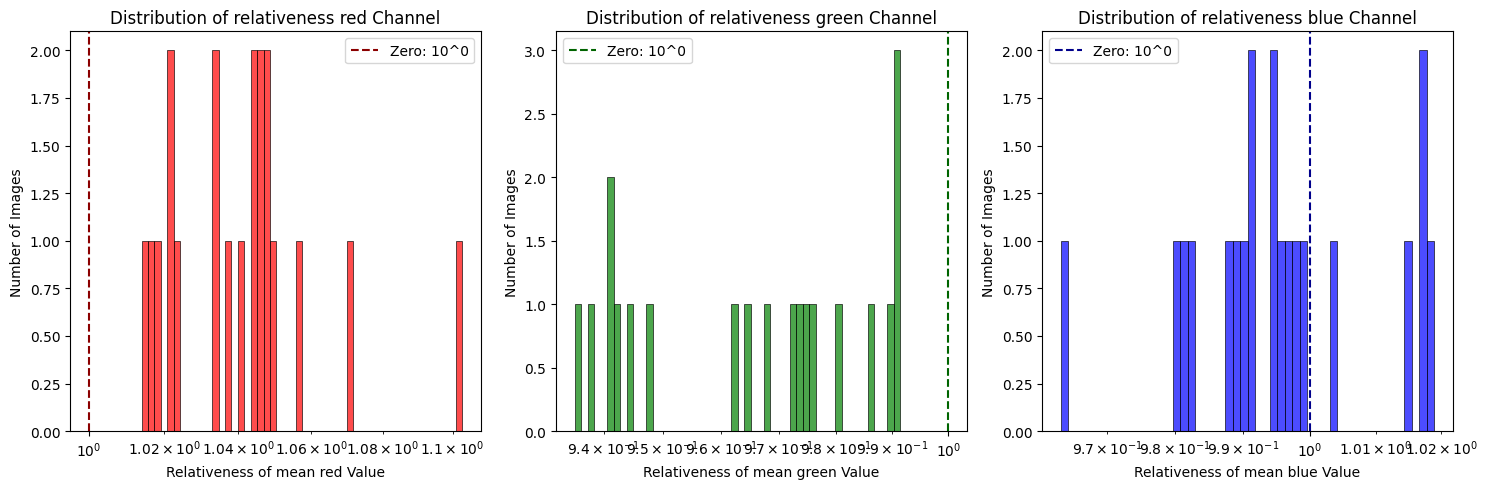

3-3


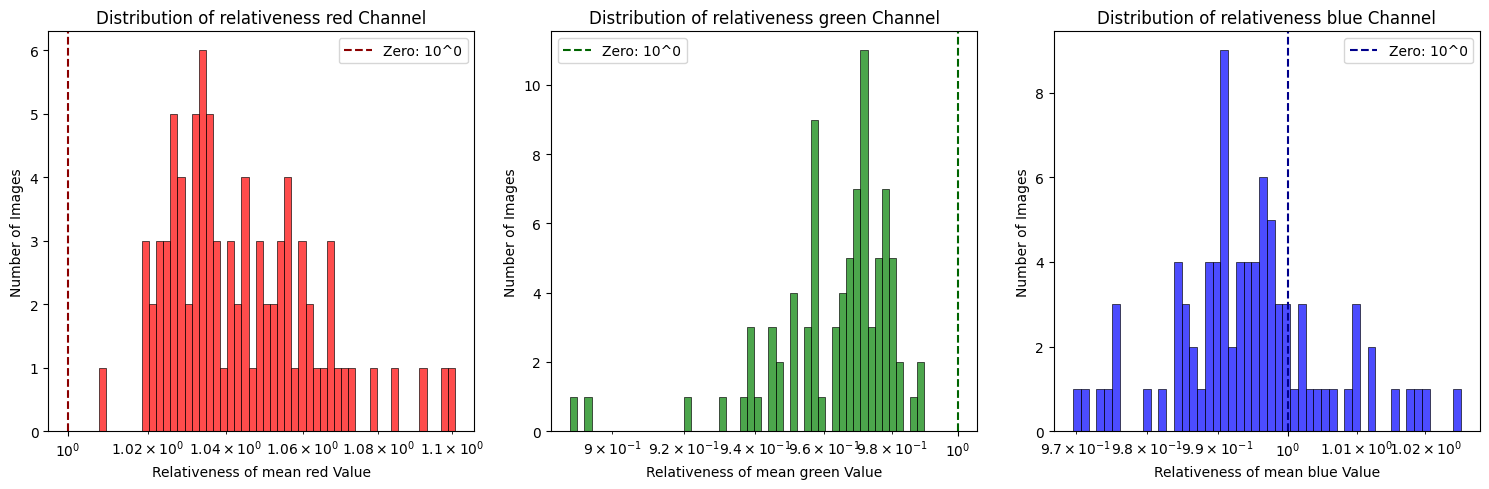

3-4


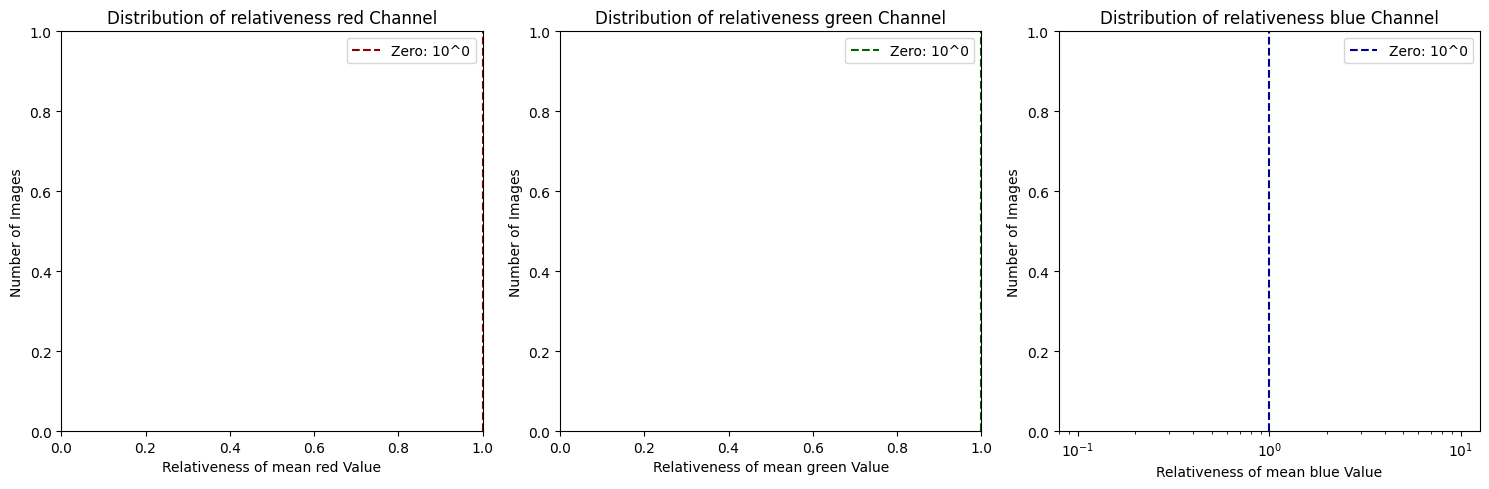

3-5


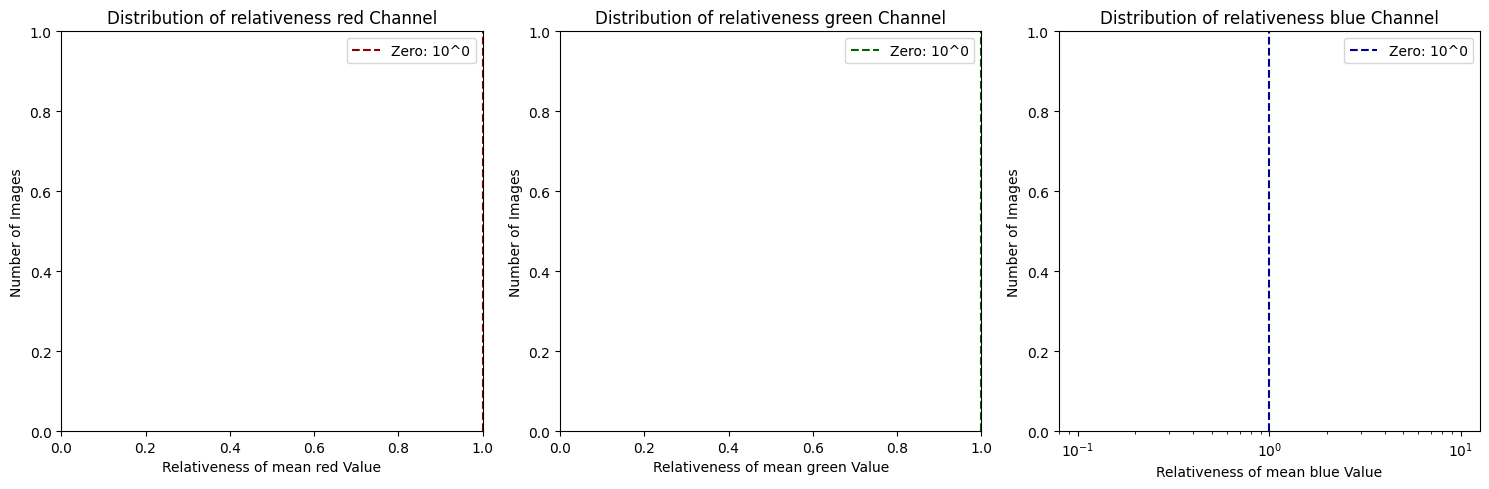

4-0


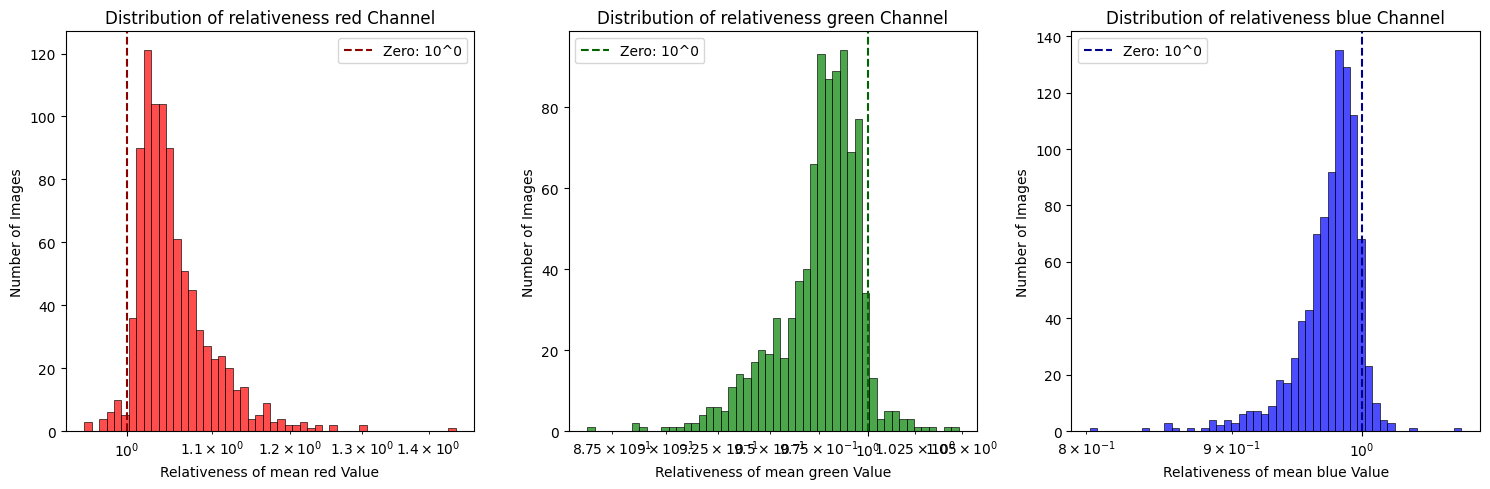

4-1


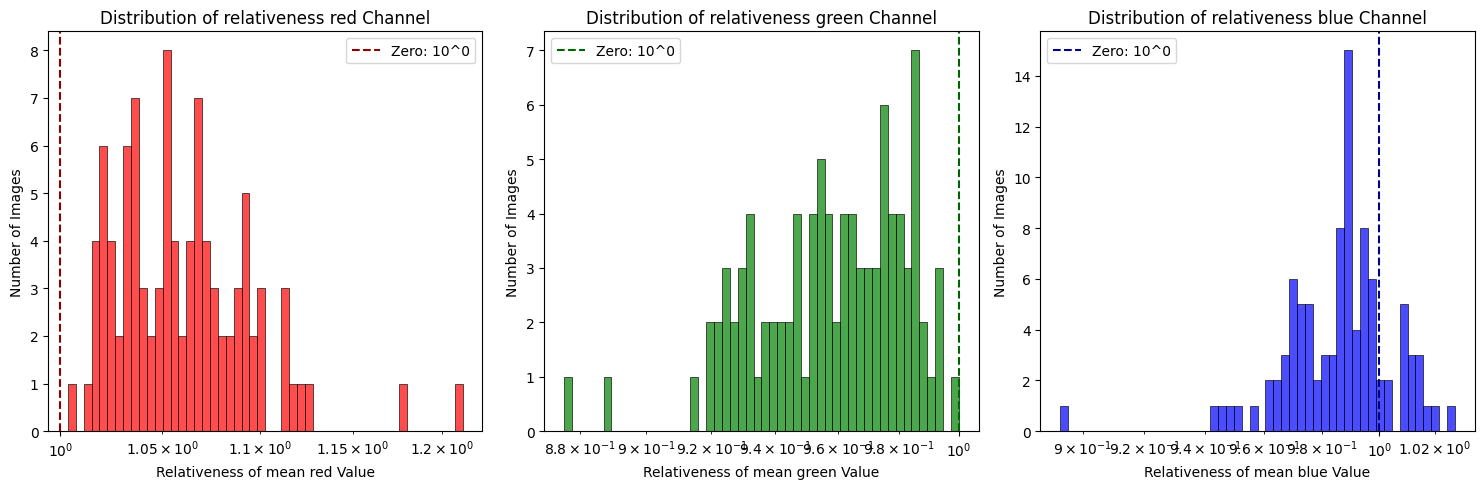

4-2


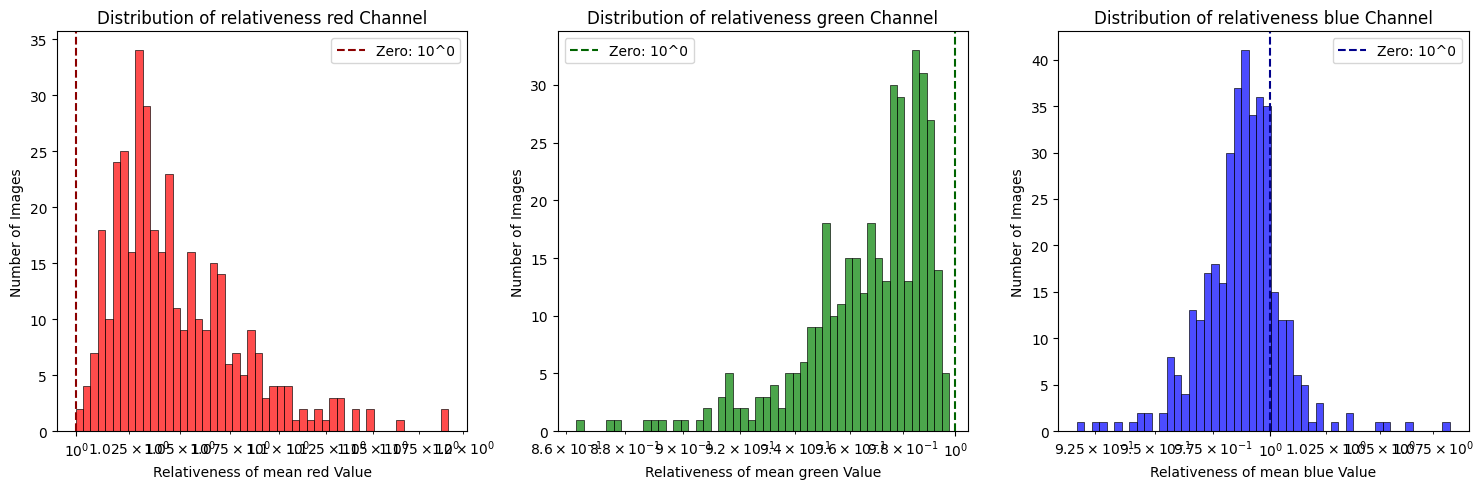

4-3


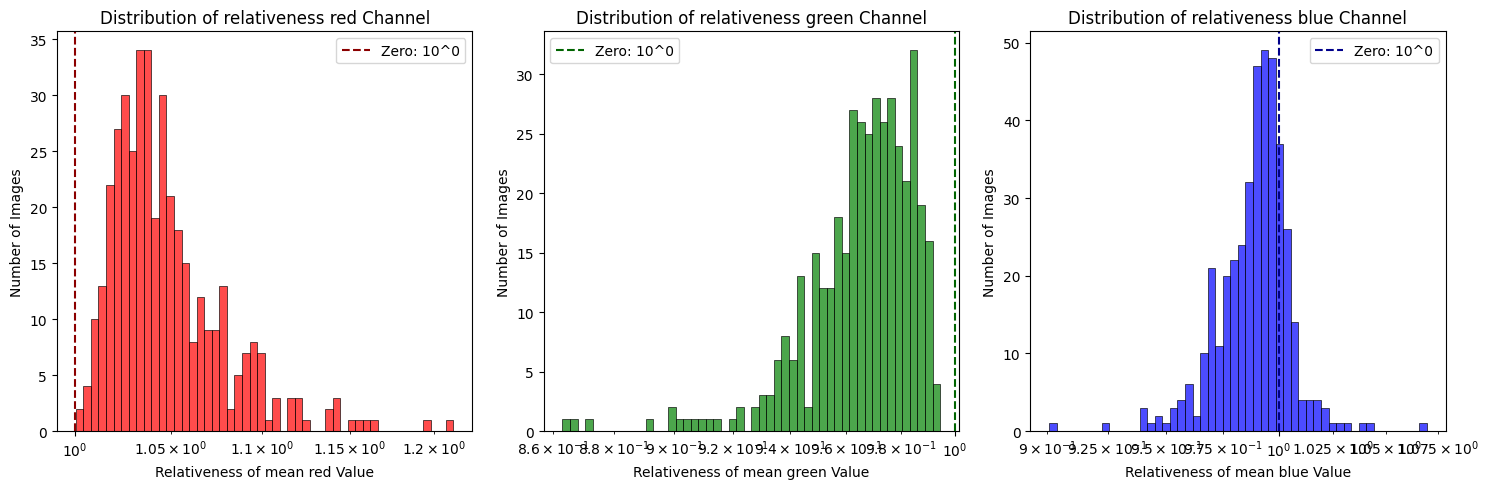

4-4


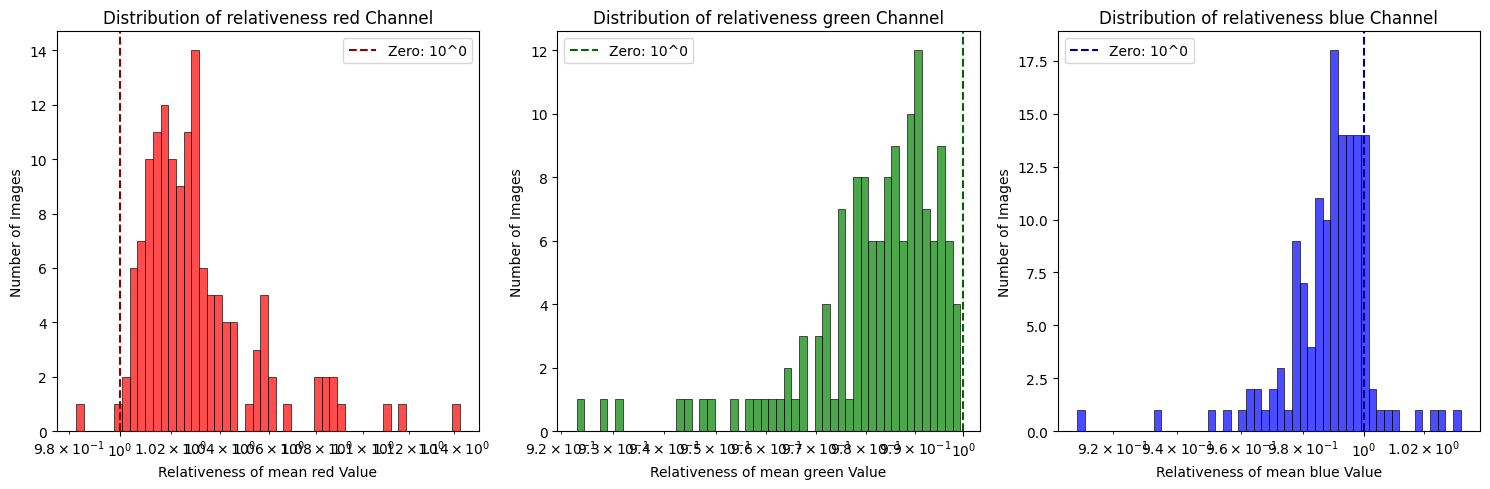

4-5


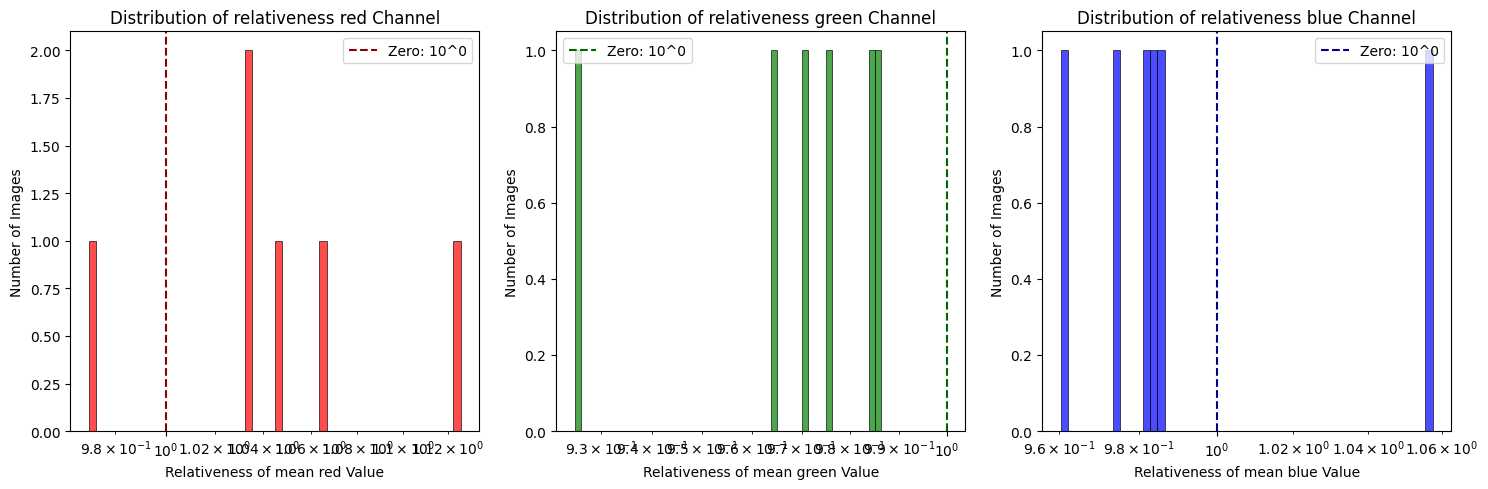

5-0


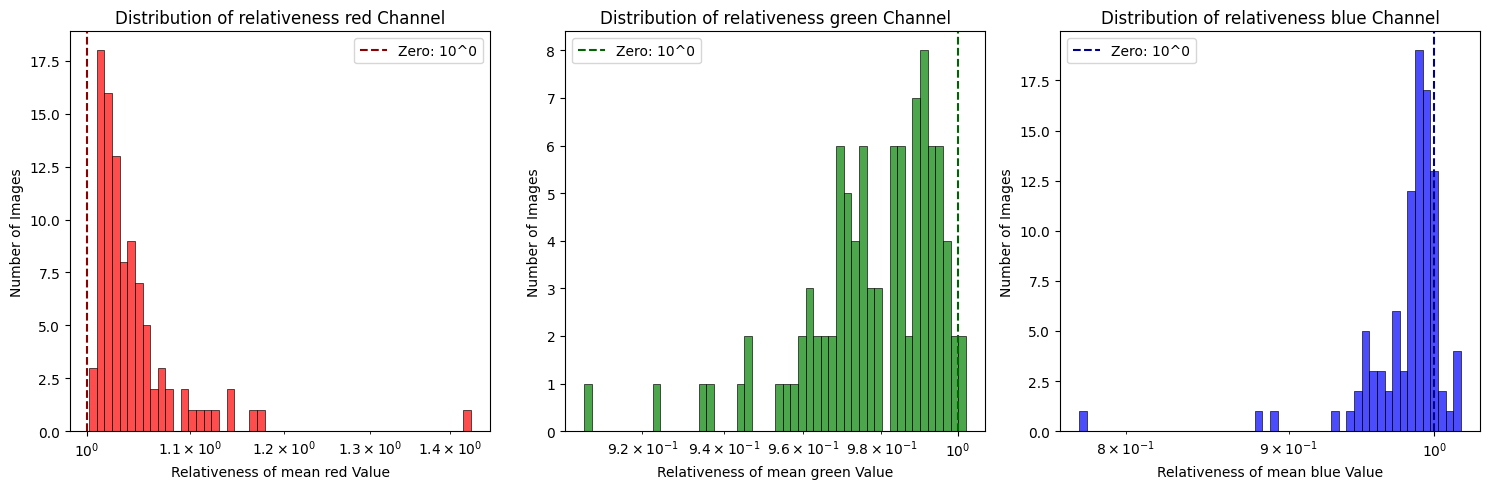

5-1


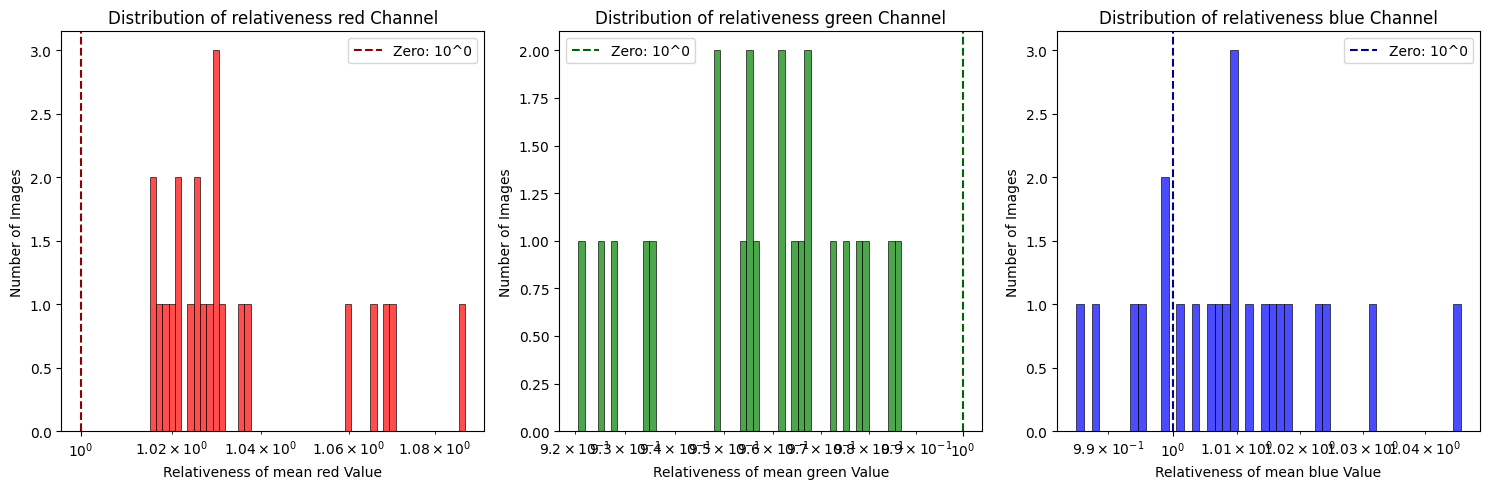

5-2


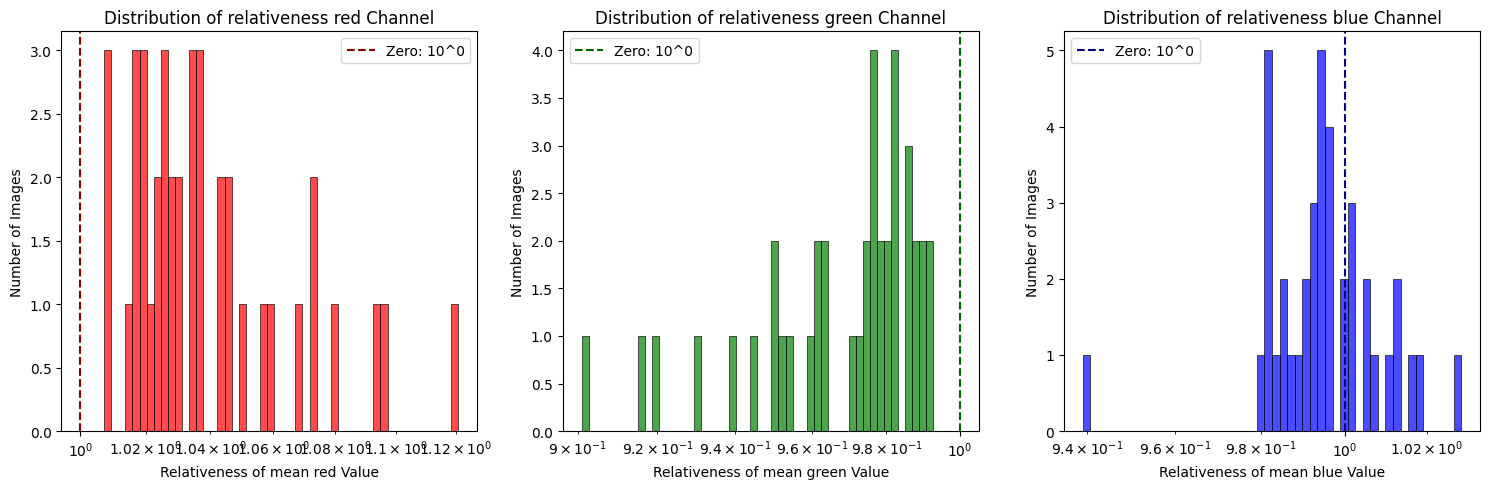

5-3


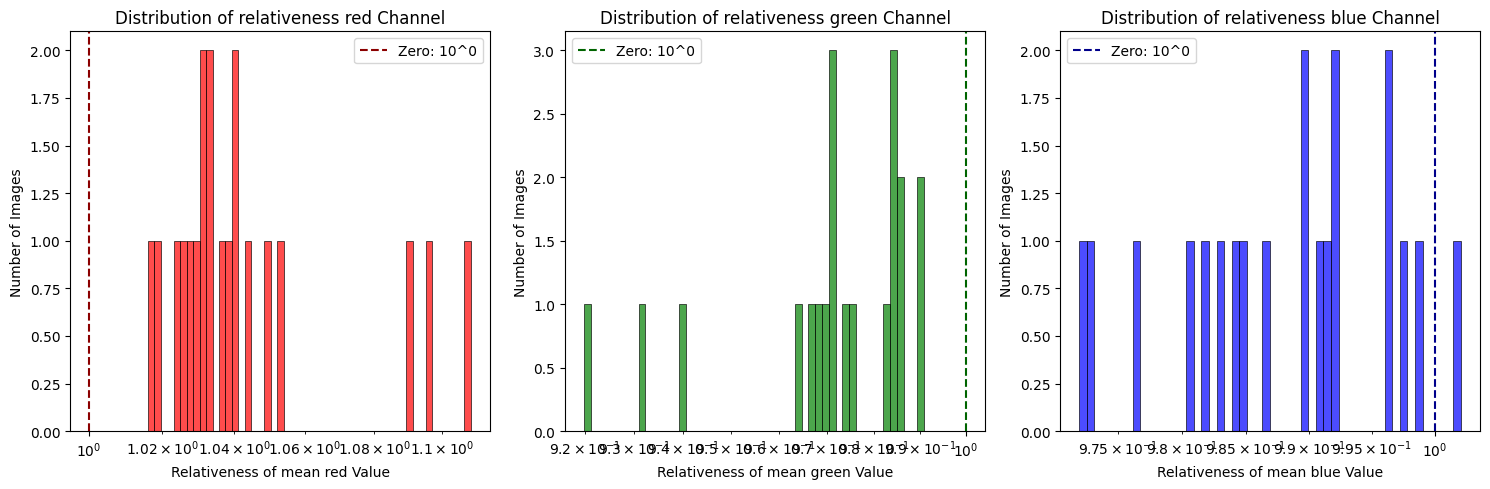

5-4


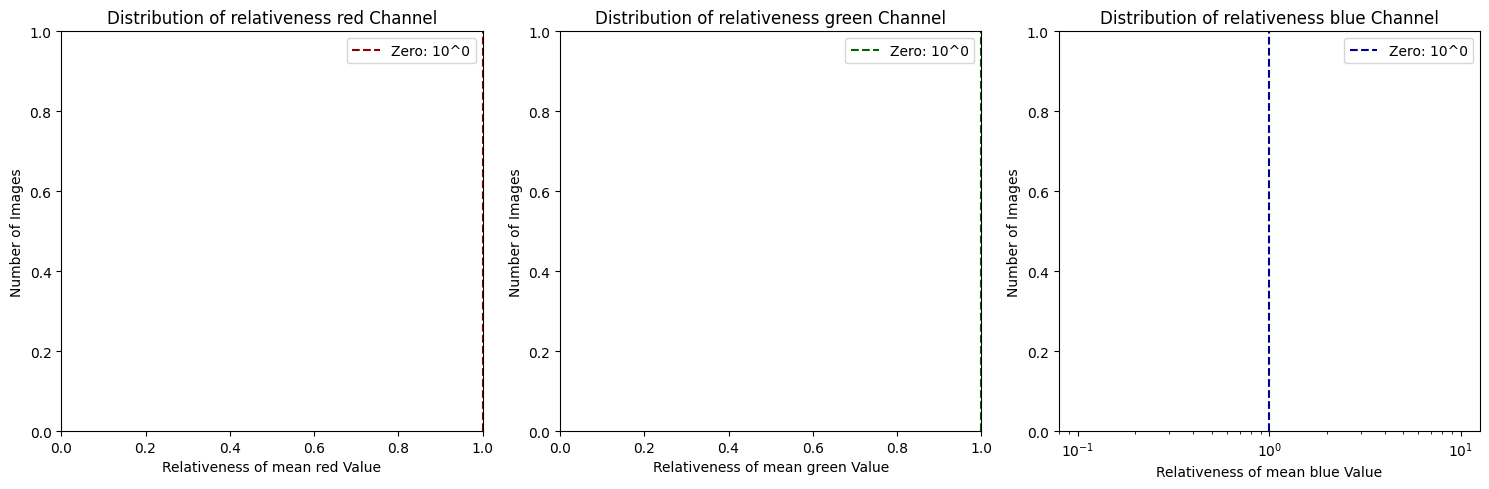

5-5


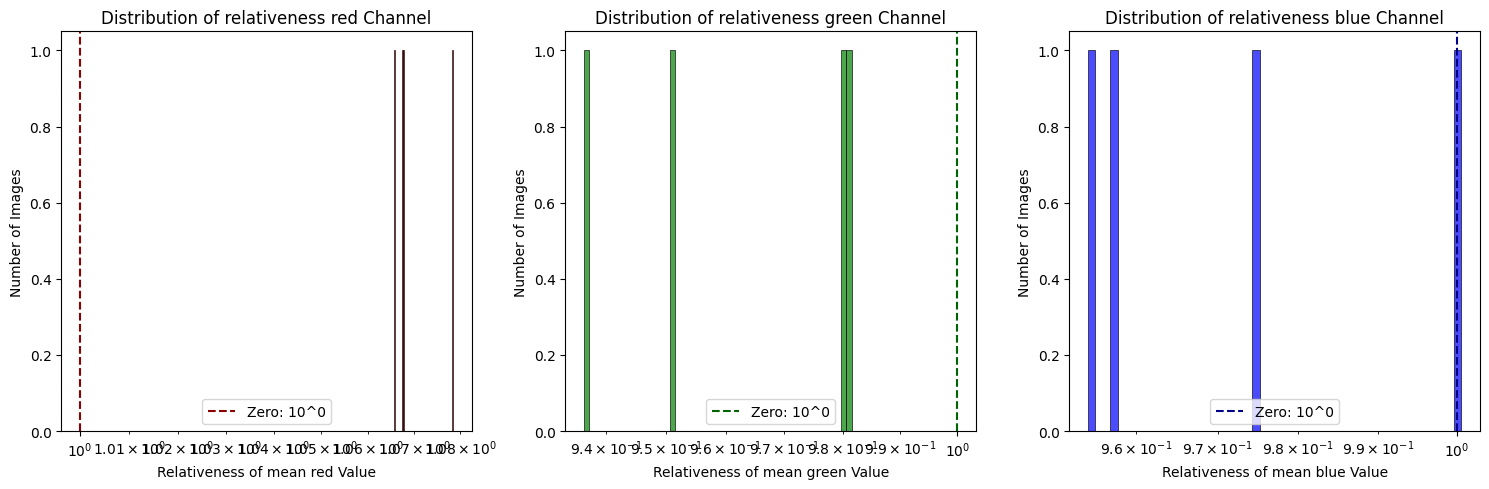

6-0


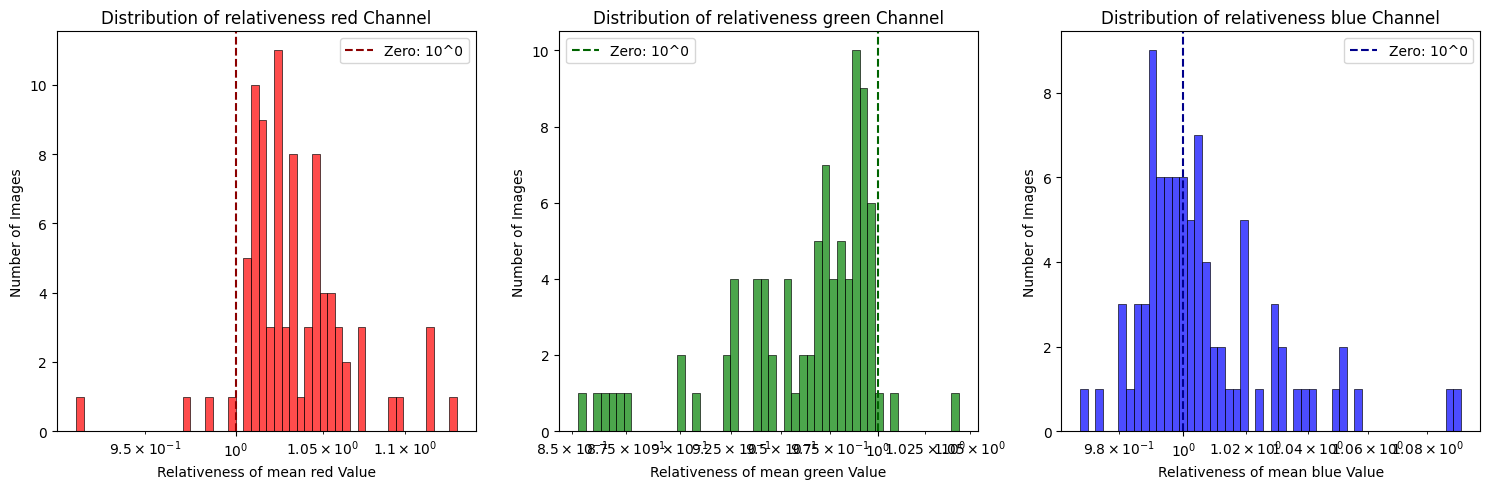

6-1


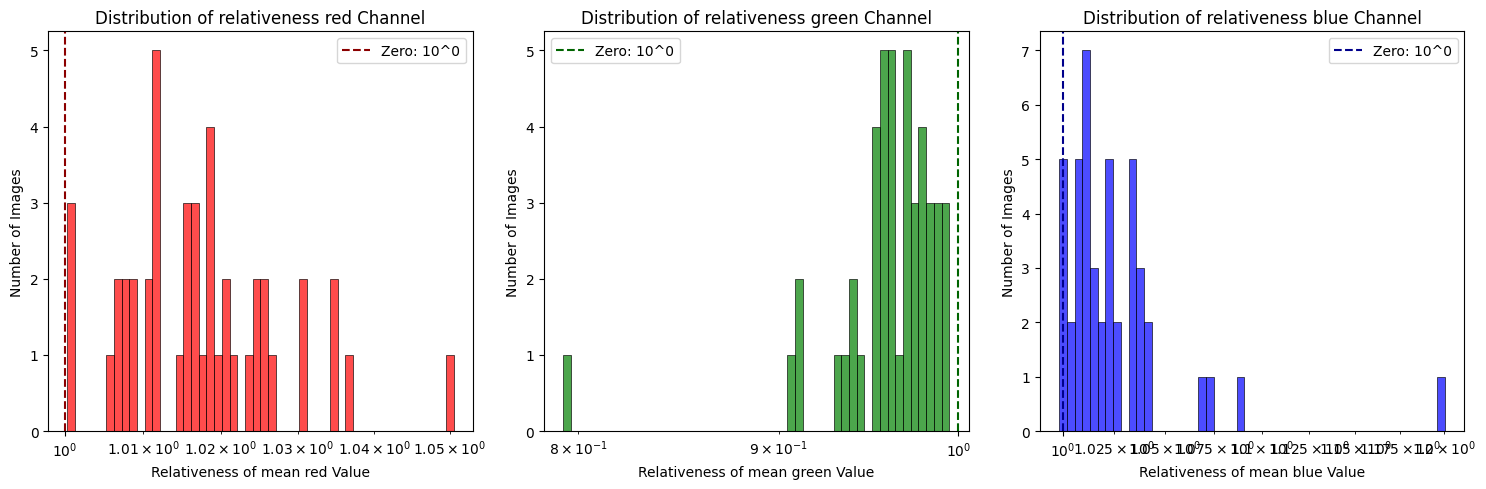

6-2


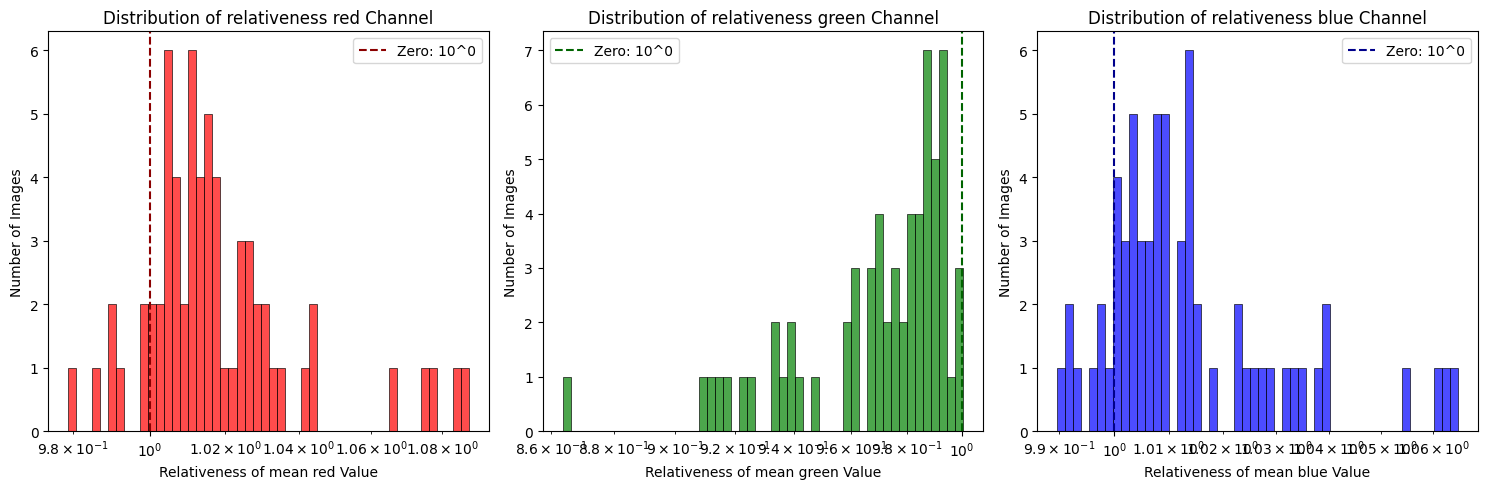

6-3


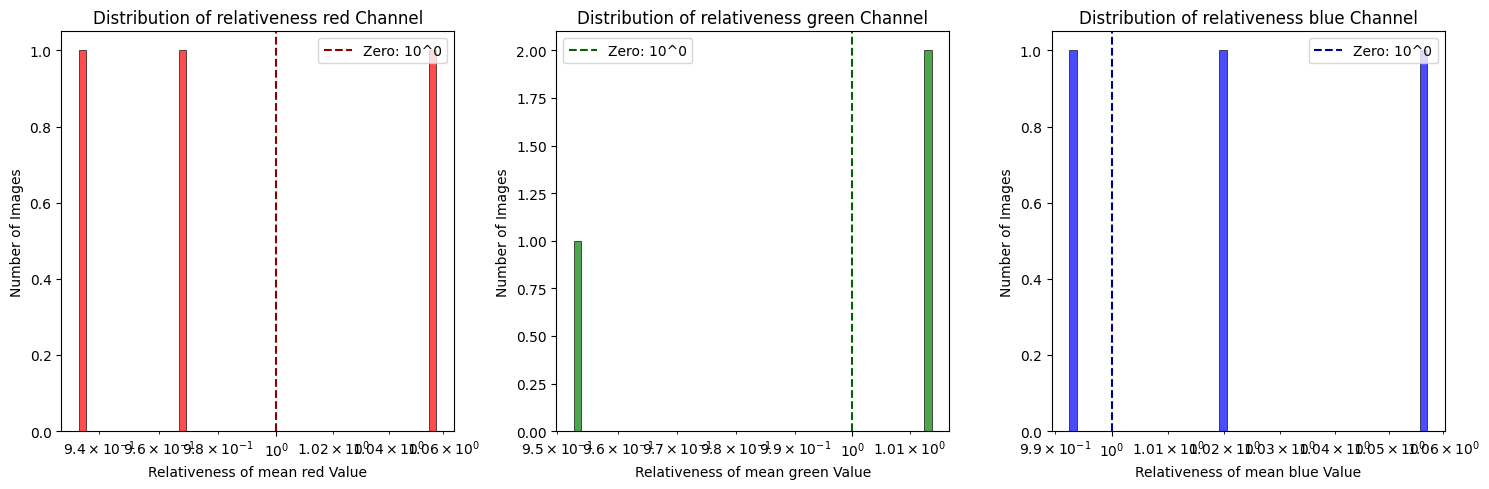

6-4


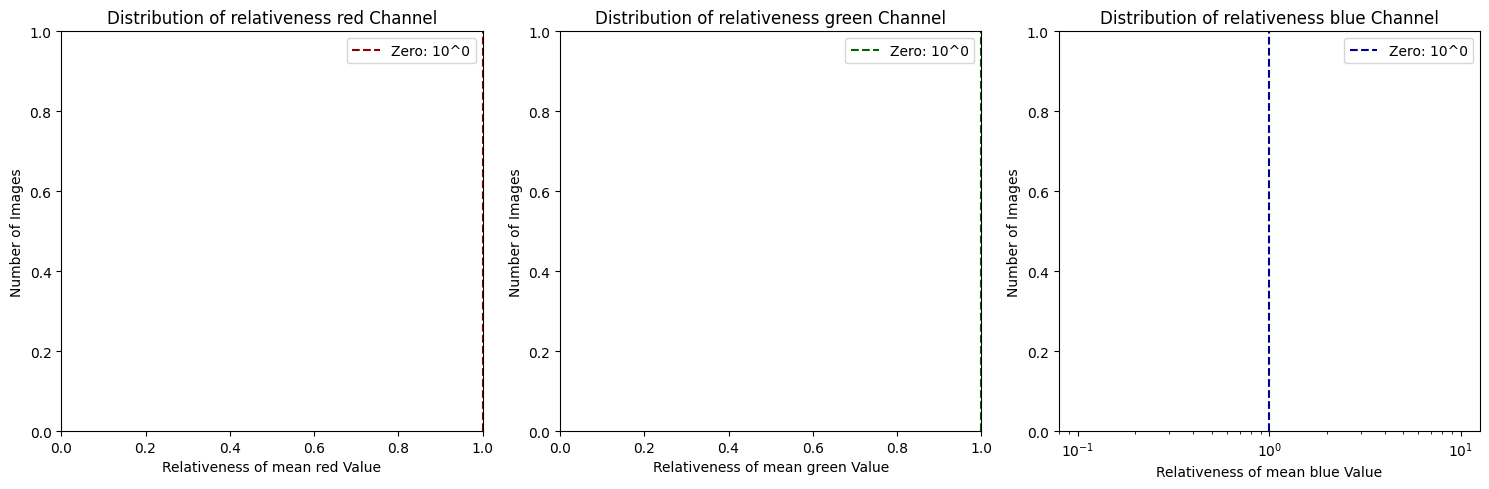

6-5


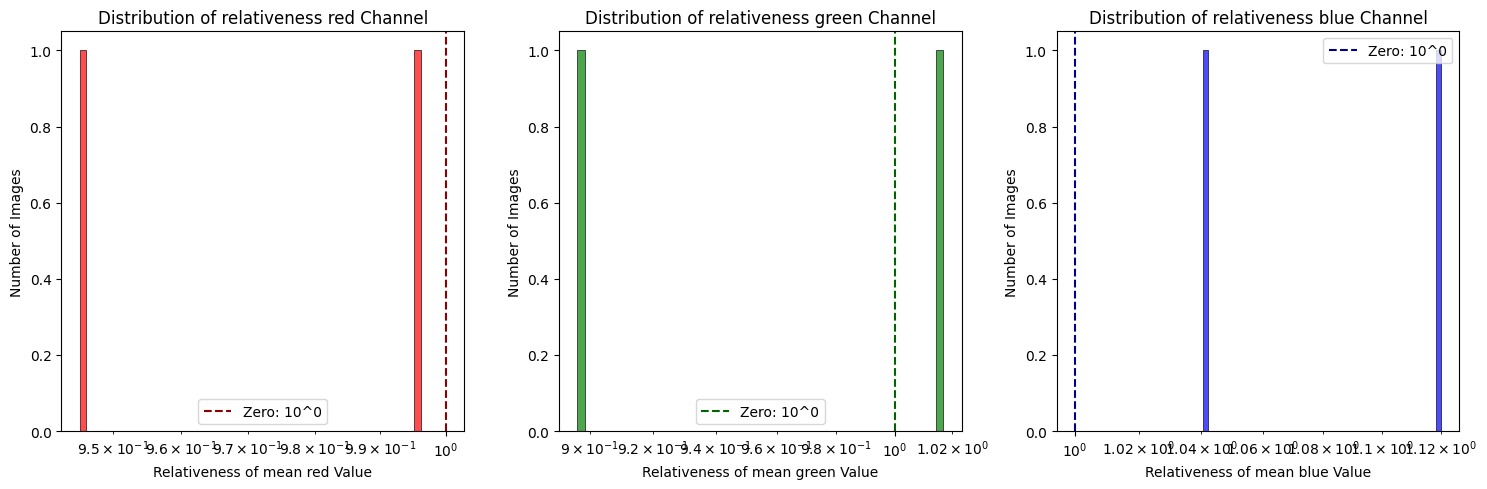

7-0


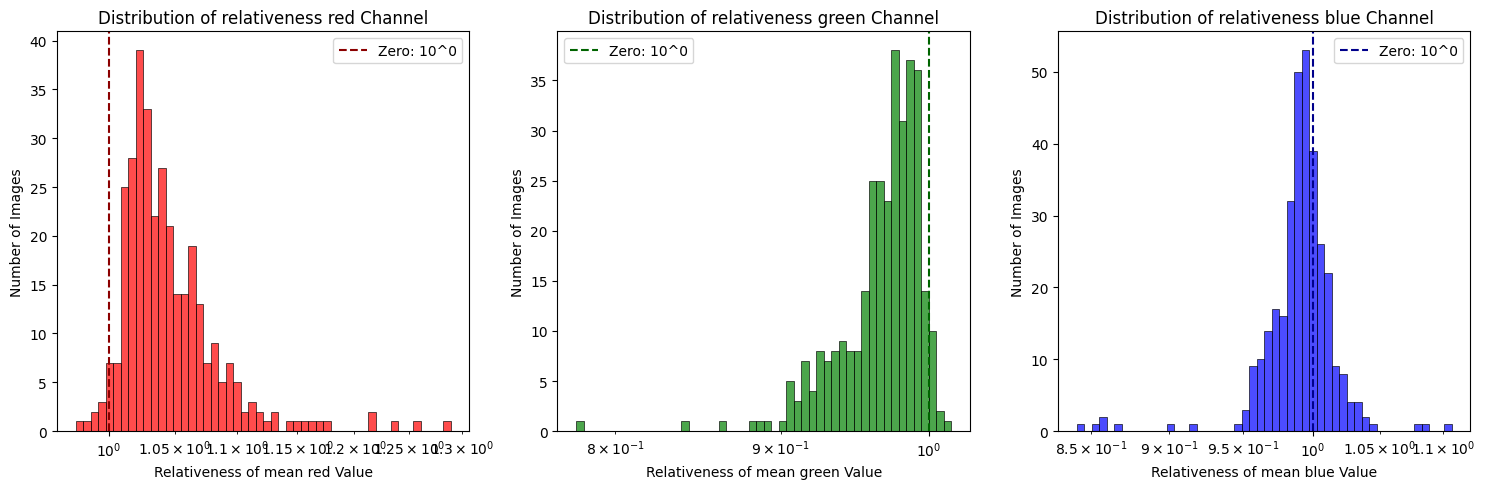

7-1


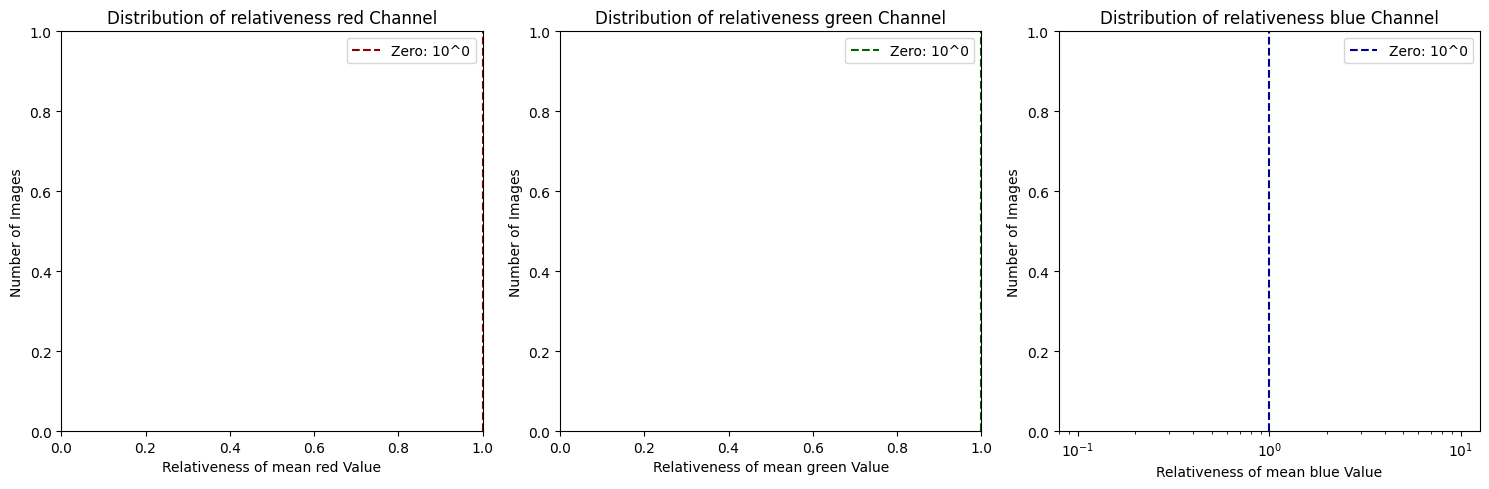

7-2


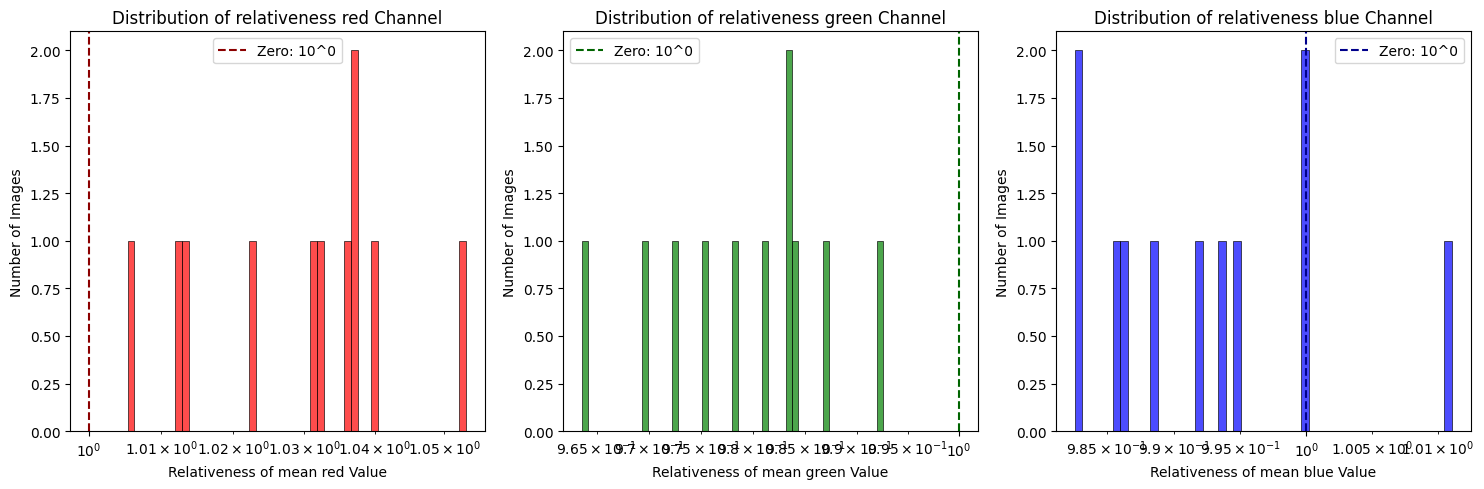

7-3


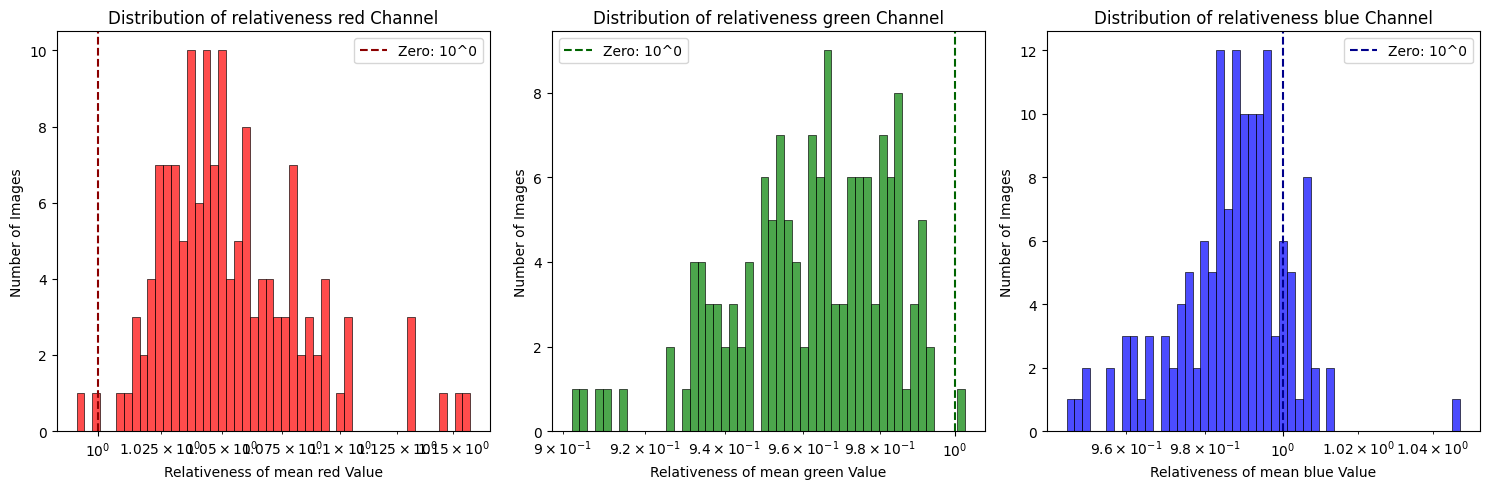

7-4


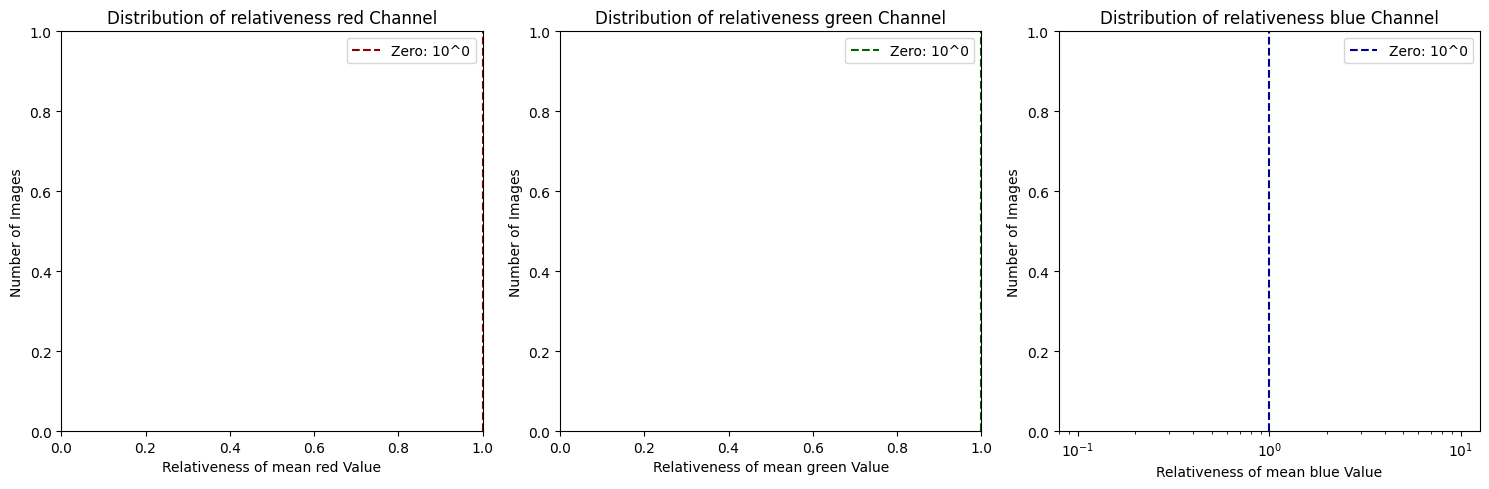

7-5


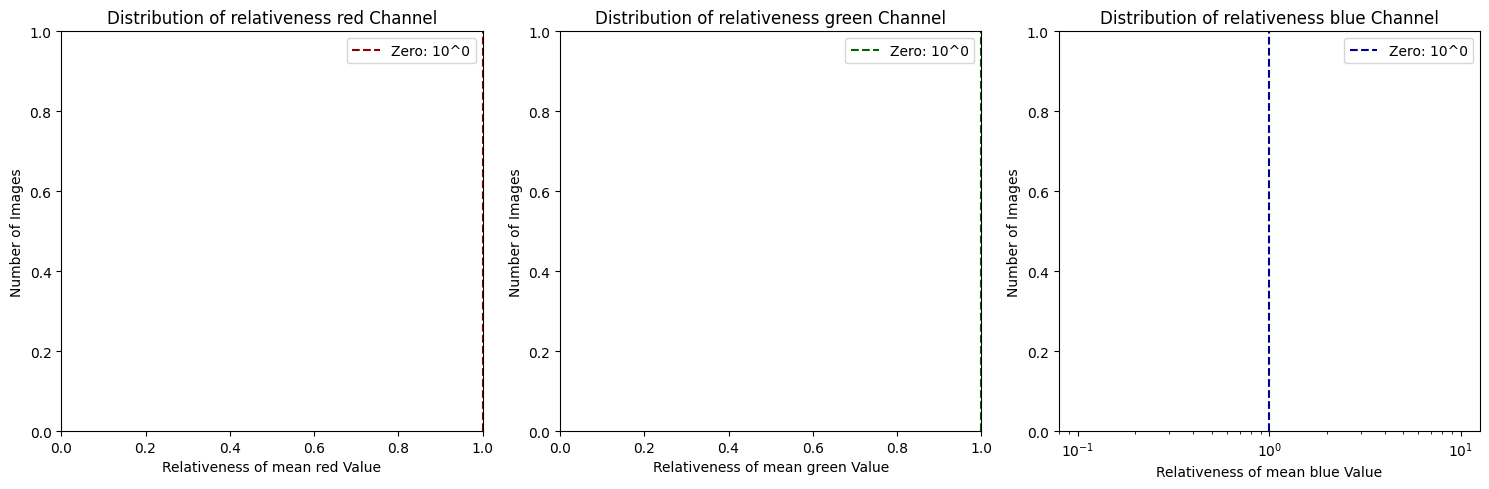

In [33]:
for label, label_name in enumerate(LABELS):
    for domain in data.center.unique():
        print("{}-{}".format(label_name, domain))
        eda.draw_color_distrib(*eda.get_colors(eda.single_generator(data, 'image', GROUP_COL, 'label', domain, label)))

1-2, 2-2, 3-0, 4-3, 6-0, 6-1, 6-2, 7-0 - c синим около нуля или больше

 Первое это label, второе - датацент

можно ничего не делать, здесь, разве что посмотреть, почему не наблюдается полного списка для одного label по всем датацентрам (условно, должно было бы быть 7-0, 7-1... 7-5)

А так можно ничего не делать поскольку цвет может быть фичей здесь 

Можно посмотреть также на пару добученных моделей к датасету. Начнем с той, которая не роняет мой ноутбук (потом еще найду хост)

In [34]:
import psutil
import torch
device = torch.device('cpu')
torch.set_num_threads(psutil.cpu_count())

In [35]:
# Usage
model = eda.models.mobilenet_v3_small(pretrained=True)
model.classifier[3] = eda.nn.Linear(model.classifier[3].in_features, len(LABELS))

transform = eda.transforms.Compose([
        eda.transforms.Resize((64, 64)),  # Small images for CPU
        eda.transforms.ToTensor(),
        eda.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_loader, val_loader = eda.create_cpu_friendly_dataloaders(data, transform)
eda.cpu_friendly_train(device, model, train_loader, val_loader, epochs=10)

/home/ubuntu/eda/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/eda/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 177MB/s]


Epoch 1/10
  Batch 0, Loss: 2.766, Acc: 6.25%
  Batch 10, Loss: 1.955, Acc: 31.25%
  Batch 20, Loss: 1.780, Acc: 40.48%
  Batch 30, Loss: 1.727, Acc: 43.35%
  Batch 40, Loss: 1.710, Acc: 42.84%
  Batch 50, Loss: 1.687, Acc: 43.26%
  Batch 60, Loss: 1.657, Acc: 43.85%
Epoch 1 Complete:
  Train Loss: 1.649, Train Acc: 44.00%
  Val Acc: 47.50%
--------------------------------------------------
Epoch 2/10
  Batch 0, Loss: 1.152, Acc: 56.25%
  Batch 10, Loss: 1.067, Acc: 64.20%
  Batch 20, Loss: 1.062, Acc: 63.69%
  Batch 30, Loss: 1.122, Acc: 62.10%
  Batch 40, Loss: 1.138, Acc: 60.52%
  Batch 50, Loss: 1.181, Acc: 57.72%
  Batch 60, Loss: 1.199, Acc: 56.97%
Epoch 2 Complete:
  Train Loss: 1.199, Train Acc: 56.80%
  Val Acc: 55.00%
--------------------------------------------------
Epoch 3/10
  Batch 0, Loss: 0.987, Acc: 62.50%
  Batch 10, Loss: 1.142, Acc: 60.80%
  Batch 20, Loss: 1.107, Acc: 61.31%
  Batch 30, Loss: 1.046, Acc: 62.70%
  Batch 40, Loss: 1.052, Acc: 60.82%
  Batch 50, Loss

около 60% аналогично

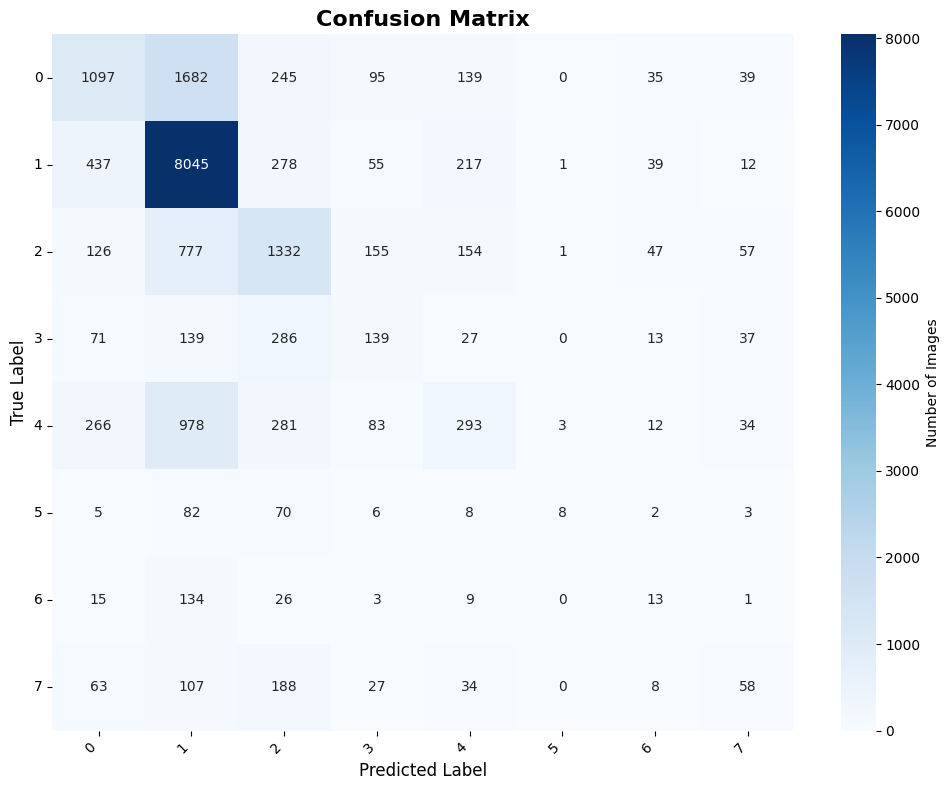

array([[1097, 1682,  245,   95,  139,    0,   35,   39],
       [ 437, 8045,  278,   55,  217,    1,   39,   12],
       [ 126,  777, 1332,  155,  154,    1,   47,   57],
       [  71,  139,  286,  139,   27,    0,   13,   37],
       [ 266,  978,  281,   83,  293,    3,   12,   34],
       [   5,   82,   70,    6,    8,    8,    2,    3],
       [  15,  134,   26,    3,    9,    0,   13,    1],
       [  63,  107,  188,   27,   34,    0,    8,   58]])

0:


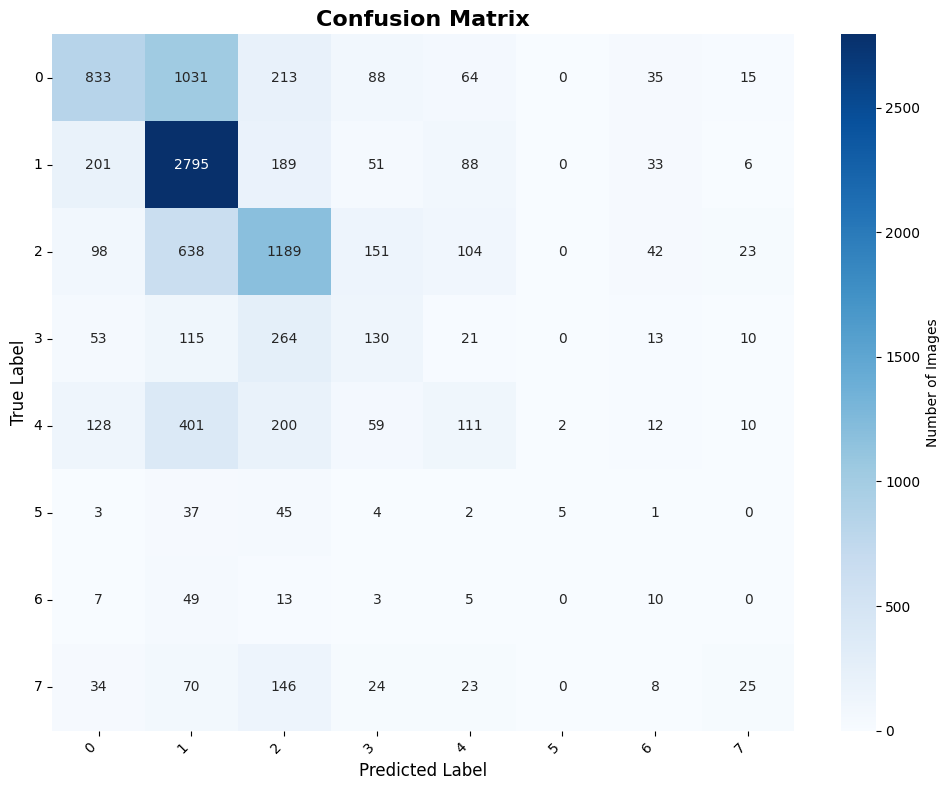

array([[ 833, 1031,  213,   88,   64,    0,   35,   15],
       [ 201, 2795,  189,   51,   88,    0,   33,    6],
       [  98,  638, 1189,  151,  104,    0,   42,   23],
       [  53,  115,  264,  130,   21,    0,   13,   10],
       [ 128,  401,  200,   59,  111,    2,   12,   10],
       [   3,   37,   45,    4,    2,    5,    1,    0],
       [   7,   49,   13,    3,    5,    0,   10,    0],
       [  34,   70,  146,   24,   23,    0,    8,   25]])

1:


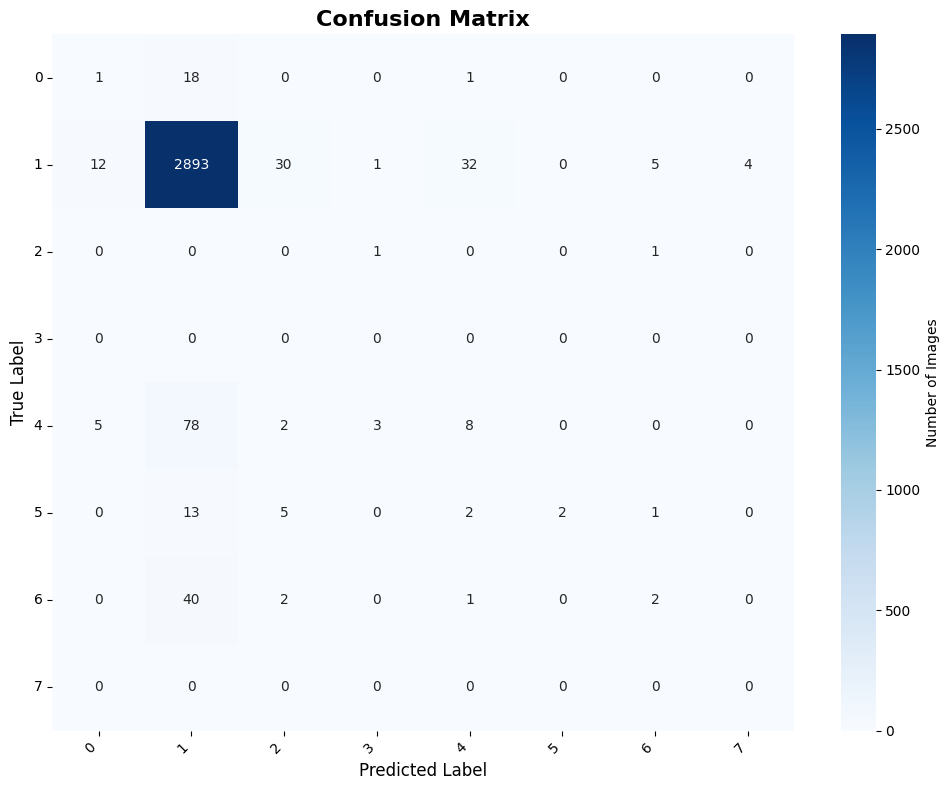

array([[   1,   18,    0,    0,    1,    0,    0,    0],
       [  12, 2893,   30,    1,   32,    0,    5,    4],
       [   0,    0,    0,    1,    0,    0,    1,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0],
       [   5,   78,    2,    3,    8,    0,    0,    0],
       [   0,   13,    5,    0,    2,    2,    1,    0],
       [   0,   40,    2,    0,    1,    0,    2,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0]])

2:


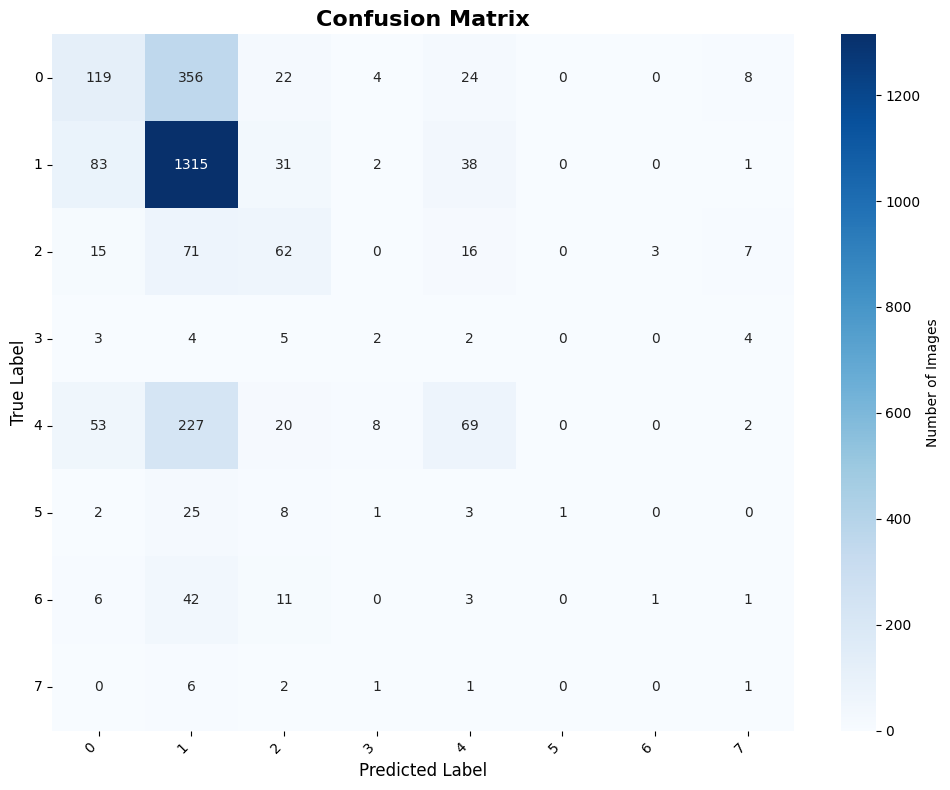

array([[ 119,  356,   22,    4,   24,    0,    0,    8],
       [  83, 1315,   31,    2,   38,    0,    0,    1],
       [  15,   71,   62,    0,   16,    0,    3,    7],
       [   3,    4,    5,    2,    2,    0,    0,    4],
       [  53,  227,   20,    8,   69,    0,    0,    2],
       [   2,   25,    8,    1,    3,    1,    0,    0],
       [   6,   42,   11,    0,    3,    0,    1,    1],
       [   0,    6,    2,    1,    1,    0,    0,    1]])

3:


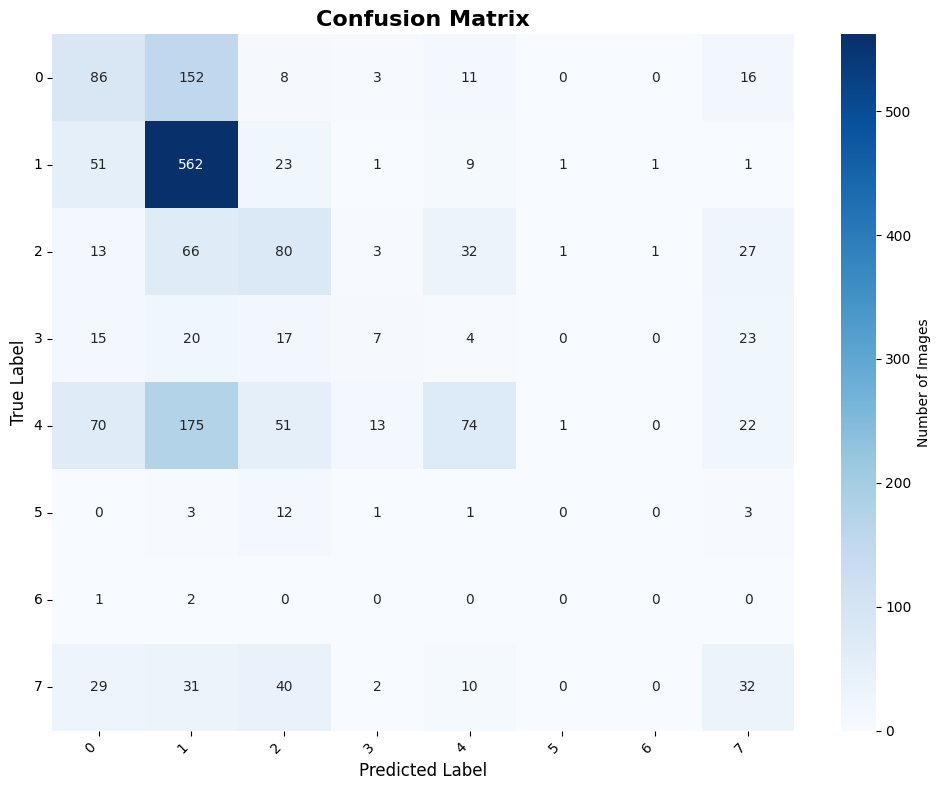

array([[ 86, 152,   8,   3,  11,   0,   0,  16],
       [ 51, 562,  23,   1,   9,   1,   1,   1],
       [ 13,  66,  80,   3,  32,   1,   1,  27],
       [ 15,  20,  17,   7,   4,   0,   0,  23],
       [ 70, 175,  51,  13,  74,   1,   0,  22],
       [  0,   3,  12,   1,   1,   0,   0,   3],
       [  1,   2,   0,   0,   0,   0,   0,   0],
       [ 29,  31,  40,   2,  10,   0,   0,  32]])

4:


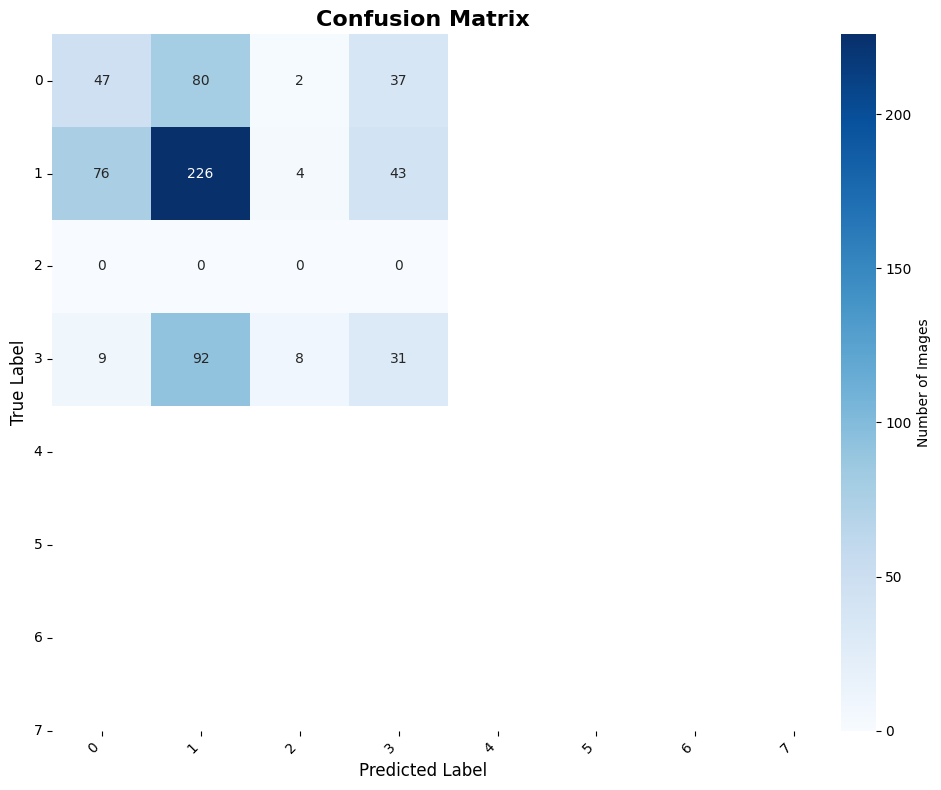

array([[ 47,  80,   2,  37],
       [ 76, 226,   4,  43],
       [  0,   0,   0,   0],
       [  9,  92,   8,  31]])

5:


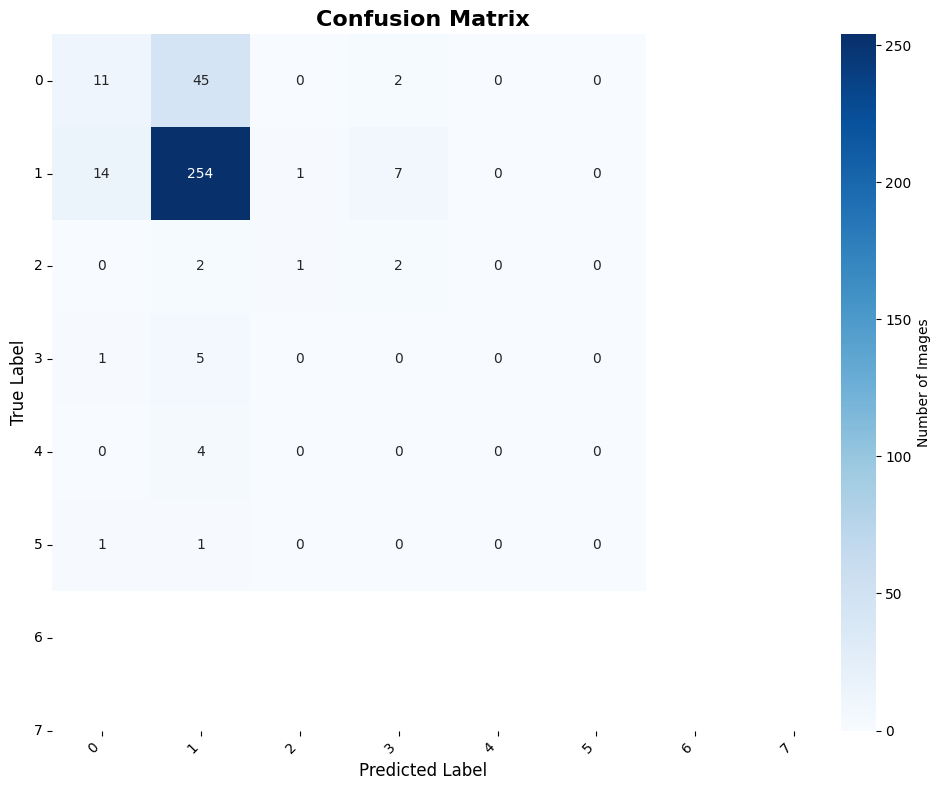

array([[ 11,  45,   0,   2,   0,   0],
       [ 14, 254,   1,   7,   0,   0],
       [  0,   2,   1,   2,   0,   0],
       [  1,   5,   0,   0,   0,   0],
       [  0,   4,   0,   0,   0,   0],
       [  1,   1,   0,   0,   0,   0]])

In [36]:
val_dataset = eda.DataFrameImageDataset(data, "image", "label", transform)
val_loader = eda.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
predictions, targets, probabilities = eda.evaluate_model(model, val_loader, device)
cm = eda.plot_confusion_matrix(targets, predictions, LABELS)
display(cm)

for domain in DOMAIN:
    print(domain, end=':\n')
    val_dataset = eda.DataFrameImageDataset(data[data[GROUP_COL] == domain], "image", "label", transform)
    val_loader = eda.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=False)
    
    
    predictions, targets, probabilities = eda.evaluate_model(model, val_loader, device)
    cm = eda.plot_confusion_matrix(targets, predictions, LABELS)
    display(cm)

In [30]:
# eda.visualize_errors(data, targets, predictions, probabilities, LABELS)

кажется, что матрицы довольно сильно перекошены на label 1, неравномерность данных (1 слишком много).

Плюс если посмотреть куда попал label 7, то в основном в первые три label-а, то есть модель переобучена

In [29]:
import importlib

importlib.reload(eda)


<module 'eda_helpers' from '/home/ubuntu/eda/eda_helpers.py'>